[View in Colaboratory](https://colab.research.google.com/github/redcican/Master-Thesis/blob/master/0_Compare_Perfomance_ML_Algorihtms.ipynb)

# Artificial Neural Network with Keras

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap

In [0]:
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn import svm

import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

## Utility Function definition

In [0]:
def plot_decision_boundary(func, X, y, figsize=(9,6)):
  amin, bmin = X.min(axis=0) - 0.1
  amax, bmax = X.max(axis=0) + 0.1
  hticks = np.linspace(amin, amax, 101)
  vticks = np.linspace(bmin, bmax, 101)
  
  aa, bb = np.meshgrid(hticks, vticks)
  ab = np.c_[aa.ravel(), bb.ravel()]
  c = func(ab)
  cc = c.reshape(aa.shape)
  
  cm = plt.cm.RdBu
  cm_bright = ListedColormap(['#FF0000','#0000FF'])
  
  fig, ax = plt.subplots(figsize=figsize)
  contour = plt.contourf(aa,bb,cc,cmap=cm,alpha=0.8)
  
  ax_c = fig.colorbar(contour)
  ax_c.set_label("$P(y=1)$")
  ax_c.set_ticks([0,0.25,0.5,0.75,1])
  
  plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_bright)
  plt.xlim(amin,amax)
  plt.ylim(bmin,bmax)

In [0]:
def plot_multiclass_decisioin_boundary(model, X, y):
  x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
  y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min,x_max,101), np.linspace(y_min,y_max,101))
  cmap = ListedColormap(['#FF0000','#00FF00','#0000FF'])
  
  Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
  Z = Z.reshape(xx.shape)
  fig = plt.figure(figsize=(8,6))
  plt.contourf(xx,yy,Z,cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [0]:
def plot_multiclass_decisioin_boundary_notNN(model, X, y):
  x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
  y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min,x_max,101), np.linspace(y_min,y_max,101))
  cmap = ListedColormap(['#FF0000','#00FF00','#0000FF'])
  
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  fig = plt.figure(figsize=(8,6))
  plt.contourf(xx,yy,Z,cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [0]:
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    fig, ax = plt.subplots()
    #plt.figure(figsize=figsize)
    ax.plot(X[y==0, 0], X[y==0, 1], 'or',alpha=1,label=0)
    ax.plot(X[y==1, 0], X[y==1, 1], 'ob',alpha=1, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    ax.set_facecolor('w')
    ax.grid(True, color='black',linestyle='-',linewidth=1,alpha=0.3)
    plt.legend()

In [0]:
def plot_loss_accuracy(history):
  historydf = pd.DataFrame(history.history, index = history.epoch)
  plt.figure(figsize=(8,6))
  historydf.plot(ylim=(0, max(1, historydf.values.max())))
  loss = history.history['loss'][-1]
  acc = history.history['acc'][-1]
  plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [0]:
# For keras
def plot_confusion_matrix(model, X, y):
  y_pred = model.predict_classes(X, verbose=0)
  plt.figure(figsize=(8,6))
  sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu',alpha=0.8,vmin=0)
  

In [0]:
# For scikit-learn
def plot_confusion(model, X,y):
  y_pred = model.predict(X)
  plt.figure(figsize=(8,6))
  sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu',alpha=0.8,vmin=0)

In [0]:
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
  dflist = []
  for history in history_list:
    h = {key: val for key, val in history.history.items() if not key.startwith('val_')}
    dflist.append(pd.DataFrame(h, index=history.epoch))
    
  historydf = pd.concat(dflist, axis=1)
  
  metrics = dflist[0].columns
  idx = pd.MultiIndex.from_product([name_list, metrics], names=['model','metric'])
  history.columns = idx
  
  plt.figure(figsize=(6,8))
  
  ax = plt.subplot(211)
  historydf.xs('loss',axis=1, level='metric').plot(ylim=(0,1),ax=ax)
  plt.title('Loss')
  
  if plot_accuracy:
    ax = plt.subplot(212)
    historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1),ax=ax)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    
  plt.tight_layout()

In [0]:
def make_sine_wave():
  c = 3
  num = 2400
  step = num/(c*4)
  np.random.seed()
  x0 = np.linspace(-c*np.pi, c*np.pi, num)
  x1 = np.sin(x0)
  noise = np.random.normal(0, 0.1, num) + 0.1
  noise = np.sign(x1) * np.abs(noise)
  x1  = x1 + noise
  x0 = x0 + (np.asarray(range(num)) / step) * 0.3
  X = np.column_stack((x0, x1))
  y = np.asarray([int((i/step)%2)==1 for i in range(len(x0))])
  return X, y

In [0]:
def make_multiclass(N=500, D=2, K=3):
  """
  N: number of points per class
  D: dimensionality
  K: number of classes
  """
  
  np.random.seed(0)
  X = np.zeros((N*K,D))
  y = np.zeros(N*K)
  for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0,1,N)
    t = np.linspace(j*4, (j+1)*4,N)+np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
  fig = plt.figure(figsize=(8,6))
  plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
  plt.xlim([-1,1])
  plt.ylim([-1,1])
  
  return X, y

# Linearly Separable data

## 1. Logistic Regression

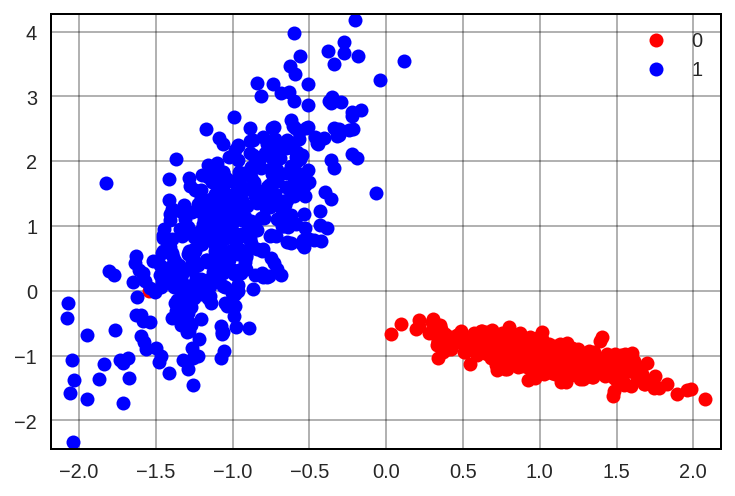

In [56]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2,
                          n_clusters_per_class=1, random_state=7)
plot_data(X, y, figsize=(9,6)) 

LR coefficients: [[-4.07231906  2.09044633]]
LR intercept: [-0.23103502]


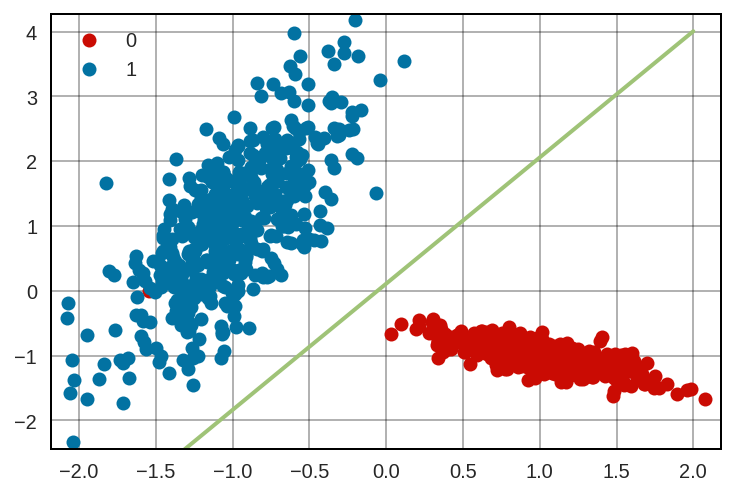

In [157]:
lr = LogisticRegression()
lr.fit(X,y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X,y)

limits = np.array([-2,2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

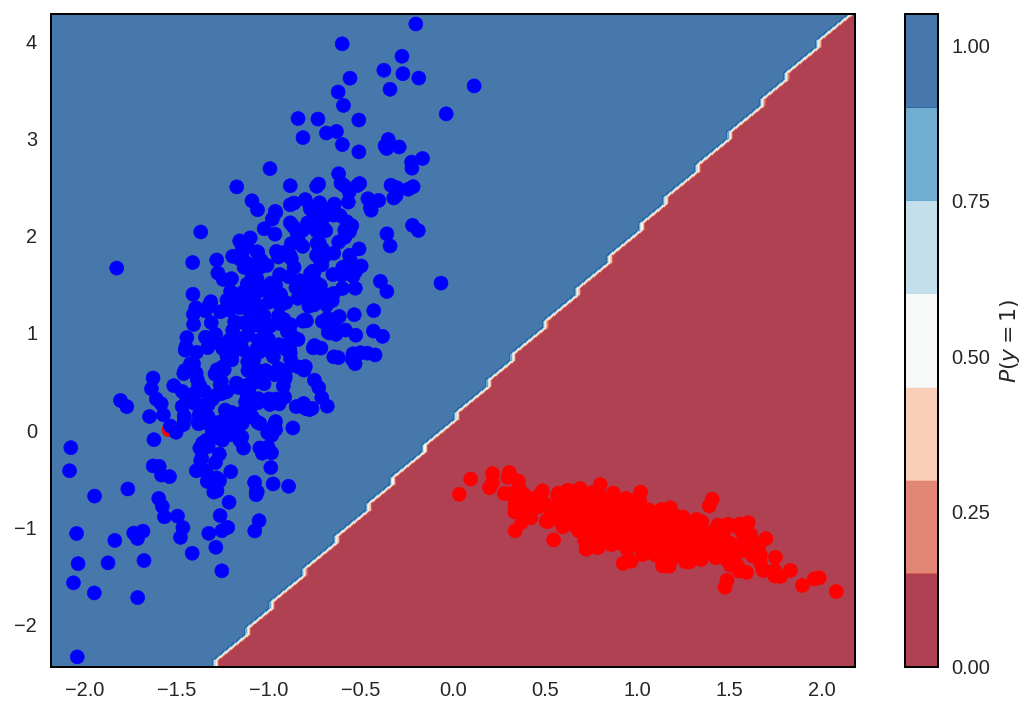

In [158]:
plot_decision_boundary(lambda x: lr.predict(x), X,y)

In [159]:
y_pred_1 = lr.predict(X)
print(classification_report(y, y_pred_1))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       501
          1       1.00      1.00      1.00       499

avg / total       1.00      1.00      1.00      1000



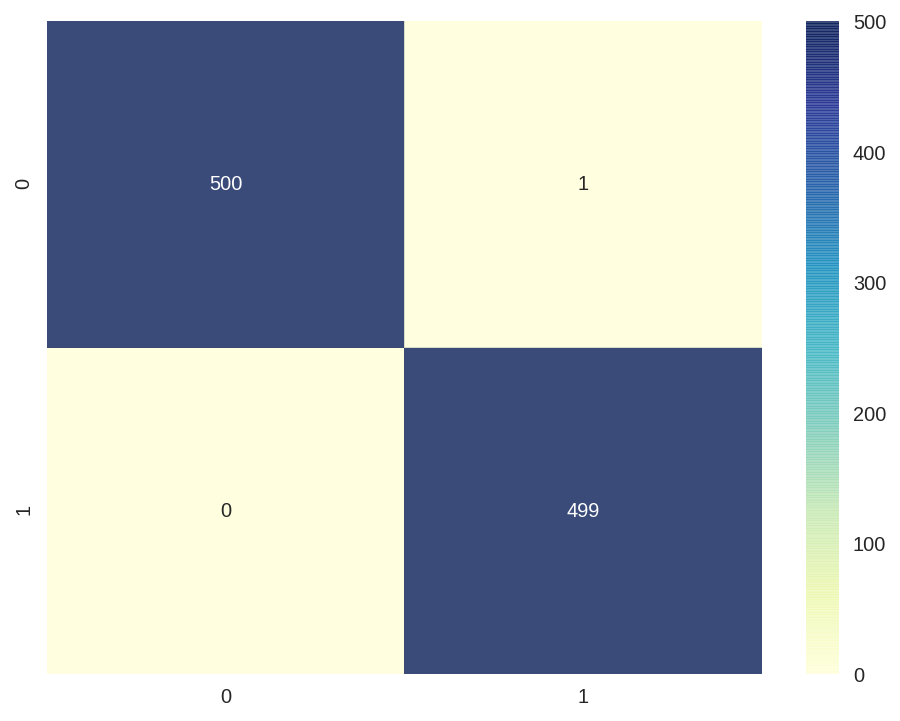

In [160]:
plot_confusion(lr, X, y)

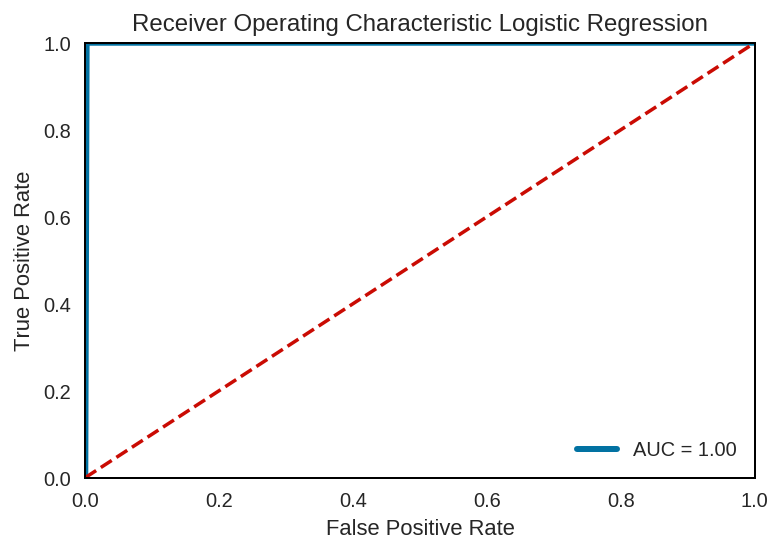

In [161]:
fpr_1, tpr_1, _= roc_curve(y,y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# method I: plt
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.plot(fpr_1, tpr_1, 'b',lw=3, label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2. Support Vector Machine

In [162]:
# support vector machine
clf = svm.SVC(C=1,kernel='rbf',gamma=10)
clf.fit(X,y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

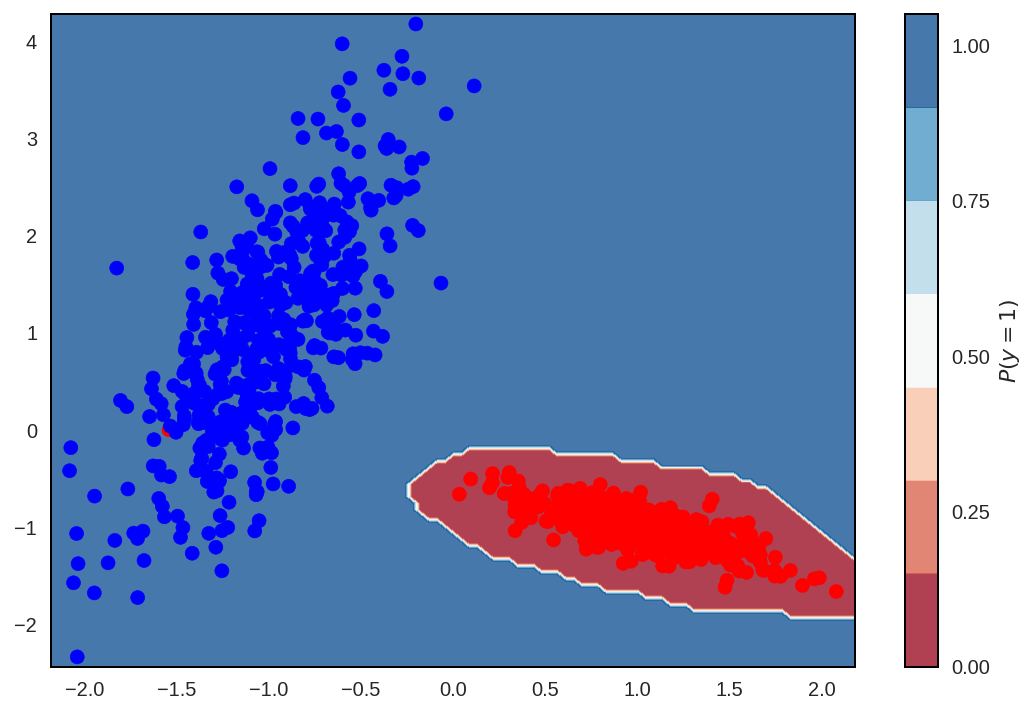

In [163]:
plot_decision_boundary(lambda x: clf.predict(x), X, y)

In [164]:
y_pred_2 = clf.predict(X)
print(classification_report(y, y_pred_2))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       501
          1       1.00      1.00      1.00       499

avg / total       1.00      1.00      1.00      1000



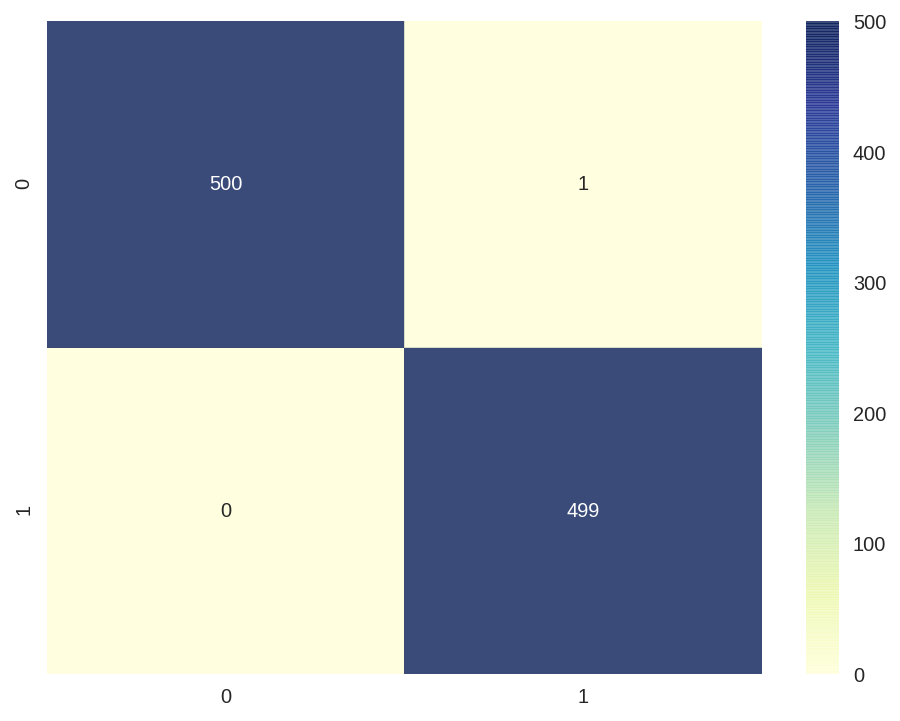

In [165]:
plot_confusion(clf, X, y)

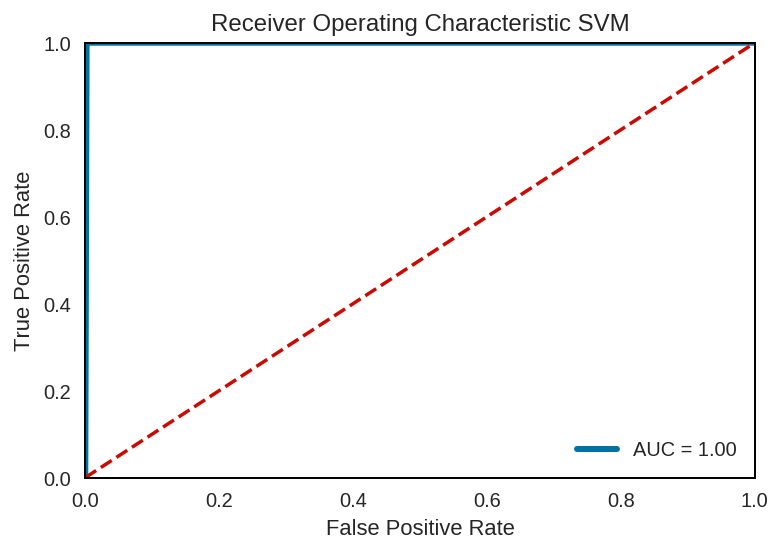

In [166]:
fpr_2, tpr_2, _= roc_curve(y,y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# method I: plt
plt.title('Receiver Operating Characteristic SVM')
plt.plot(fpr_2, tpr_2, 'b',lw=3 ,label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3. Neural Network

### shallow NN

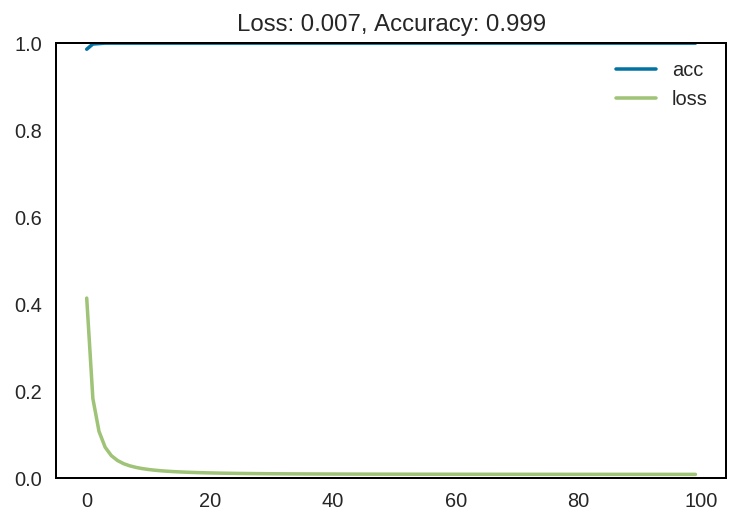

In [171]:
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

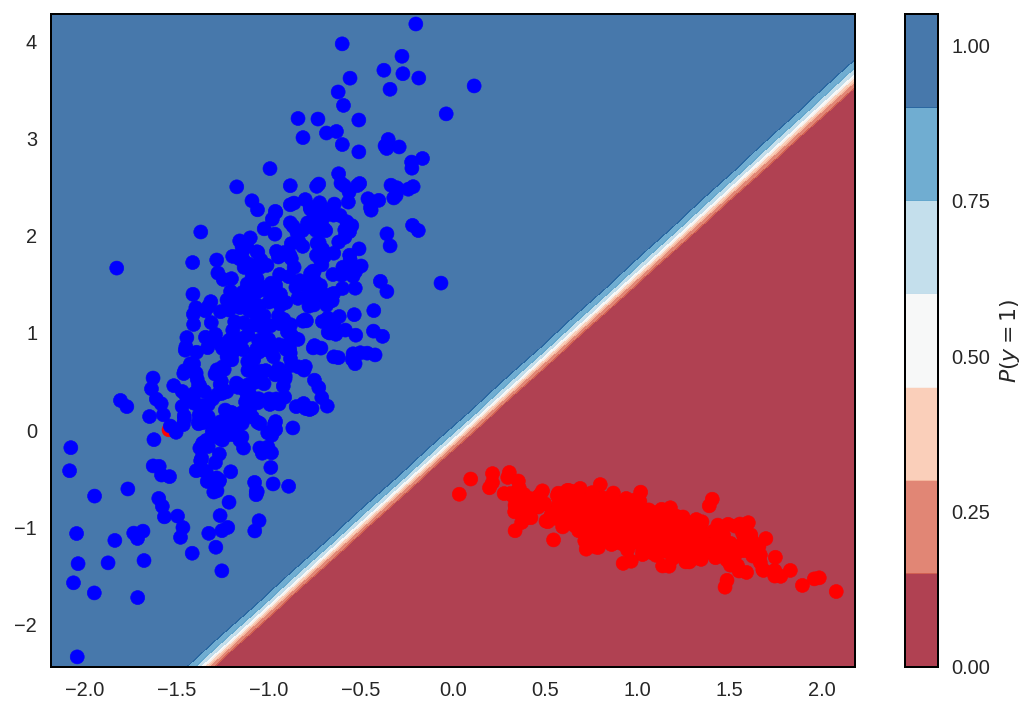

In [172]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

In [173]:
y_pred_3 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_3))

1000/1000 [==============================] - 0s 57us/step
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       501
          1       1.00      1.00      1.00       499

avg / total       1.00      1.00      1.00      1000



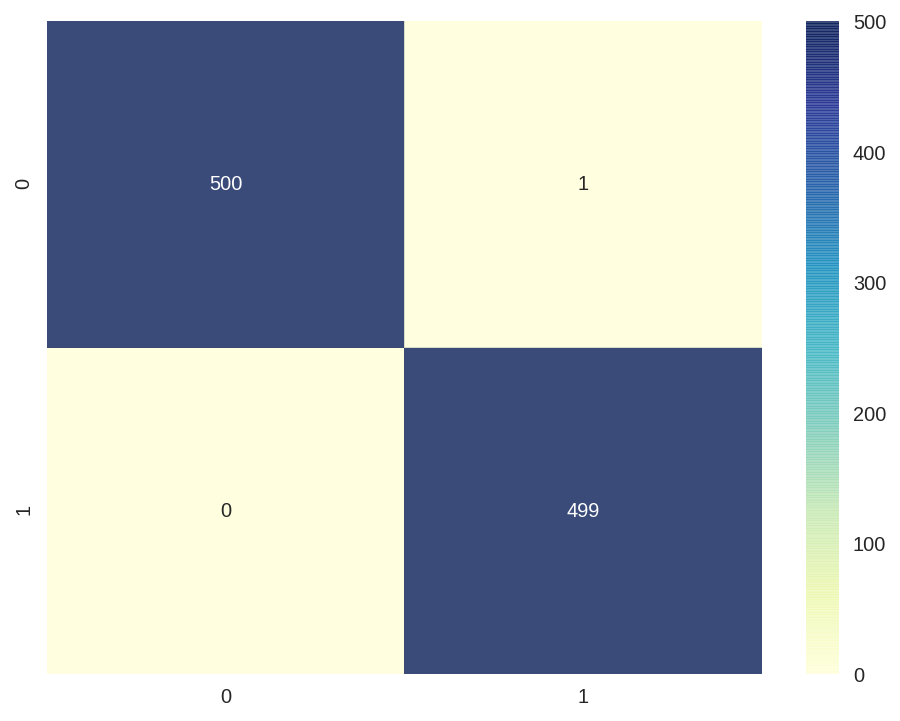

In [174]:
plot_confusion_matrix(model, X, y)

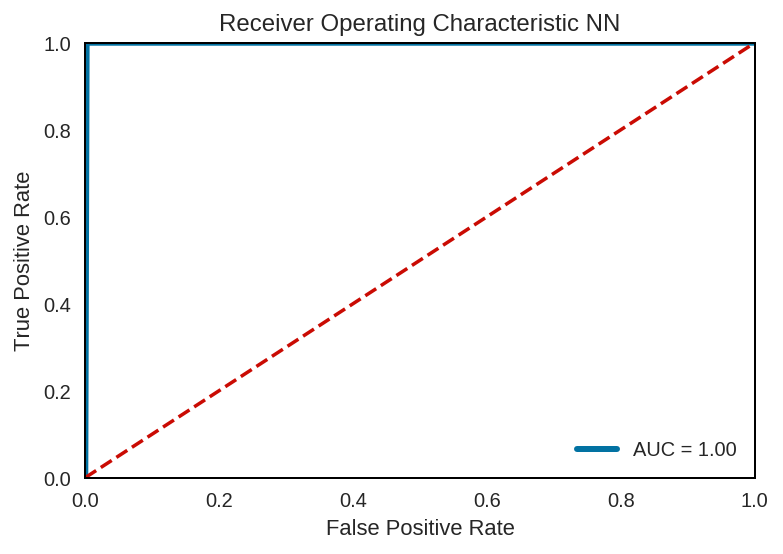

In [175]:
fpr_3, tpr_3, _= roc_curve(y,y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# method I: plt
plt.title('Receiver Operating Characteristic NN')
plt.plot(fpr_3, tpr_3, 'b',lw=3, label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Deep NN

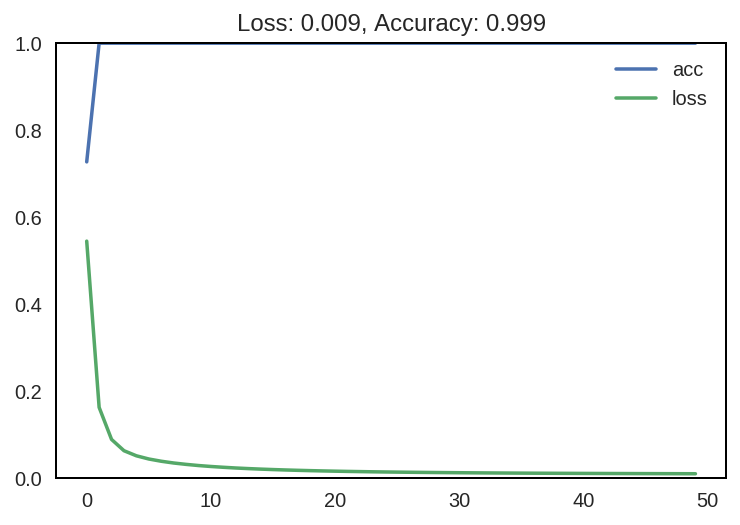

In [57]:
model = Sequential()

model.add(Dense(32, input_shape=(2,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y,verbose=0, epochs=50)

plot_loss_accuracy(history)

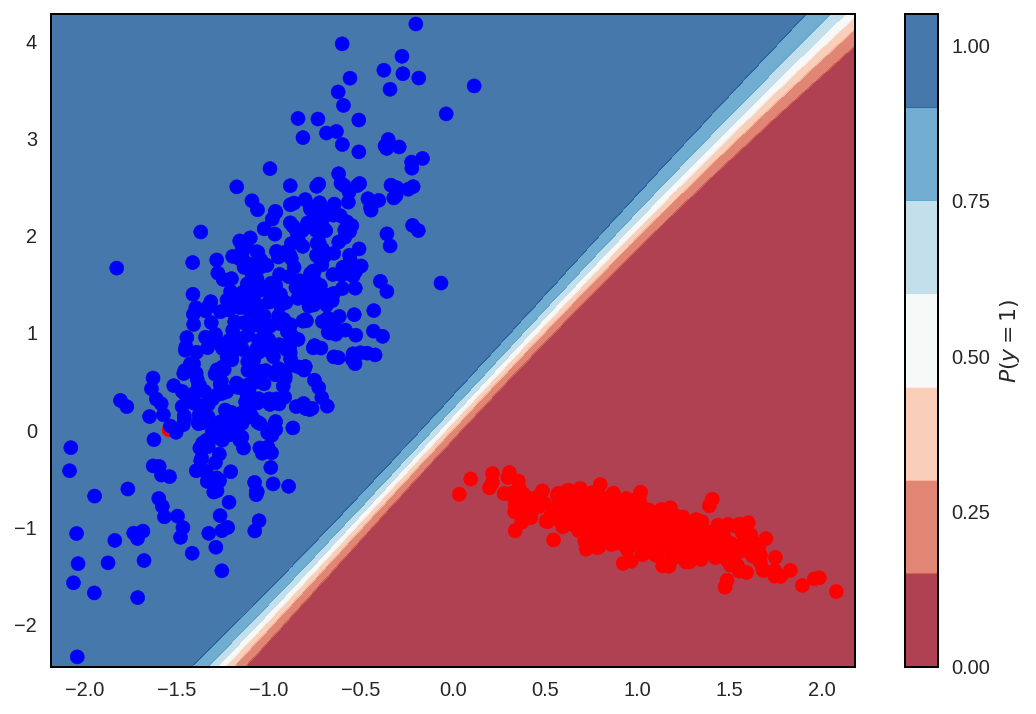

In [58]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

1000/1000 [==============================] - 0s 48us/step
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       501
          1       1.00      1.00      1.00       499

avg / total       1.00      1.00      1.00      1000



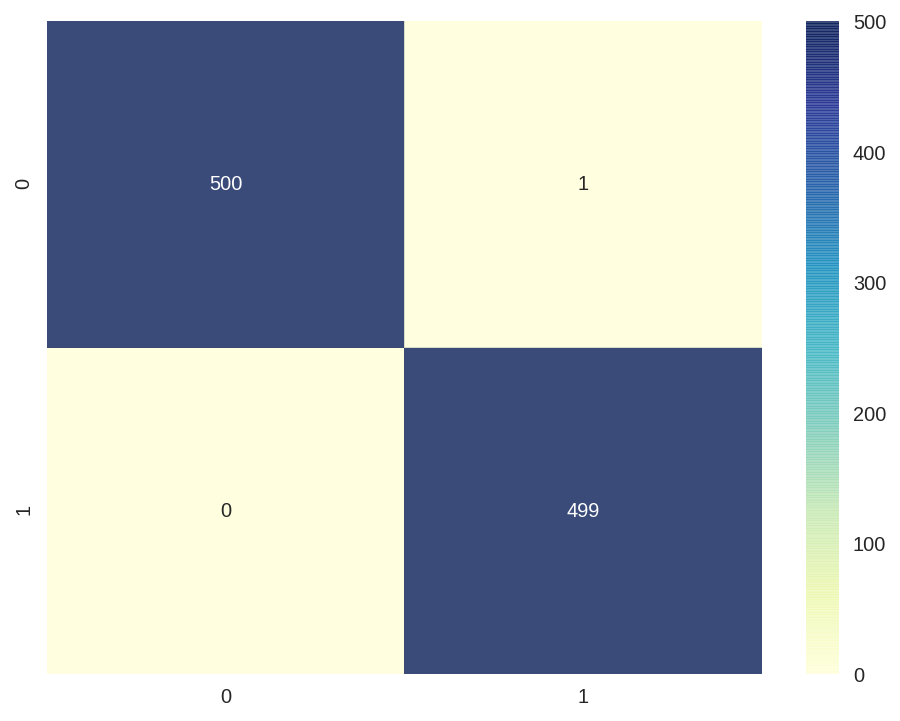

In [59]:
y_pred_4 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_4))
plot_confusion_matrix(model, X, y)

#  Complex Data - Moons

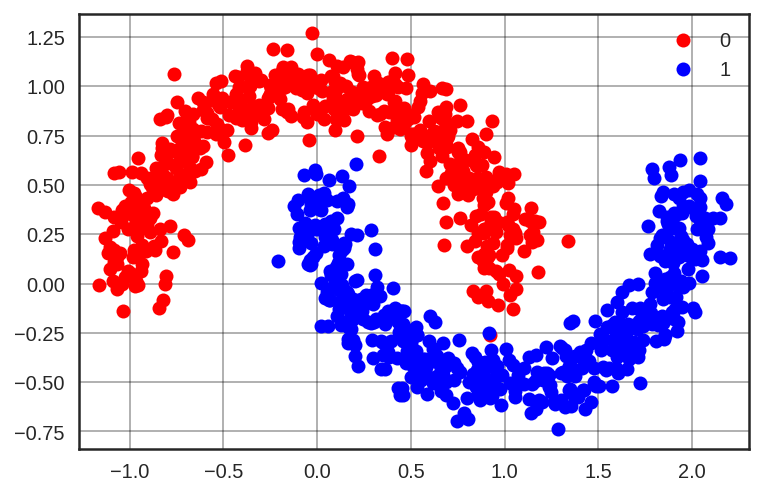

In [51]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
plot_data(X,y)

## 1. Logistic Regression

Epoch 1/100
1000/1000 [==============================] - 1s 650us/step - loss: 0.6368 - acc: 0.6790
Epoch 2/100
1000/1000 [==============================] - 0s 154us/step - loss: 0.6256 - acc: 0.6750
Epoch 3/100
1000/1000 [==============================] - 0s 174us/step - loss: 0.6151 - acc: 0.6790
Epoch 4/100
1000/1000 [==============================] - 0s 164us/step - loss: 0.6049 - acc: 0.6810
Epoch 5/100
1000/1000 [==============================] - 0s 162us/step - loss: 0.5952 - acc: 0.6720
Epoch 6/100
1000/1000 [==============================] - 0s 156us/step - loss: 0.5860 - acc: 0.6650
Epoch 7/100
1000/1000 [==============================] - 0s 162us/step - loss: 0.5771 - acc: 0.6660
Epoch 8/100
1000/1000 [==============================] - 0s 187us/step - loss: 0.5687 - acc: 0.6720
Epoch 9/100
1000/1000 [==============================] - 0s 157us/step - loss: 0.5607 - acc: 0.6740
Epoch 10/100
1000/1000 [==============================] - 0s 164us/step - loss: 0.5530 - acc: 0.6770

Epoch 21/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.4874 - acc: 0.7280
Epoch 22/100
1000/1000 [==============================] - 0s 157us/step - loss: 0.4828 - acc: 0.7280
Epoch 23/100
1000/1000 [==============================] - 0s 167us/step - loss: 0.4783 - acc: 0.7310
Epoch 24/100
1000/1000 [==============================] - 0s 182us/step - loss: 0.4741 - acc: 0.7310
Epoch 25/100
1000/1000 [==============================] - 0s 184us/step - loss: 0.4699 - acc: 0.7320
Epoch 26/100
1000/1000 [==============================] - 0s 177us/step - loss: 0.4659 - acc: 0.7360
Epoch 27/100
1000/1000 [==============================] - 0s 186us/step - loss: 0.4621 - acc: 0.7390
Epoch 28/100
1000/1000 [==============================] - 0s 179us/step - loss: 0.4584 - acc: 0.7440
Epoch 29/100
1000/1000 [==============================] - 0s 177us/step - loss: 0.4548 - acc: 0.7460
Epoch 30/100
1000/1000 [==============================] - 0s 192us/step - loss: 0.4513 - ac

Epoch 40/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.4218 - acc: 0.7660
Epoch 41/100
1000/1000 [==============================] - 0s 164us/step - loss: 0.4193 - acc: 0.7650
Epoch 42/100
1000/1000 [==============================] - 0s 177us/step - loss: 0.4169 - acc: 0.7660
Epoch 43/100
1000/1000 [==============================] - 0s 181us/step - loss: 0.4145 - acc: 0.7700
Epoch 44/100
1000/1000 [==============================] - 0s 174us/step - loss: 0.4121 - acc: 0.7700
Epoch 45/100
1000/1000 [==============================] - 0s 174us/step - loss: 0.4098 - acc: 0.7740
Epoch 46/100
1000/1000 [==============================] - 0s 179us/step - loss: 0.4076 - acc: 0.7740
Epoch 47/100
1000/1000 [==============================] - 0s 174us/step - loss: 0.4054 - acc: 0.7760
Epoch 48/100
1000/1000 [==============================] - 0s 180us/step - loss: 0.4032 - acc: 0.7770
Epoch 49/100
1000/1000 [==============================] - 0s 190us/step - loss: 0.4011 - ac

1000/1000 [==============================] - 0s 168us/step - loss: 0.3840 - acc: 0.7940
Epoch 59/100
1000/1000 [==============================] - 0s 183us/step - loss: 0.3822 - acc: 0.7950
Epoch 60/100
1000/1000 [==============================] - 0s 165us/step - loss: 0.3805 - acc: 0.7980
Epoch 61/100
1000/1000 [==============================] - 0s 170us/step - loss: 0.3788 - acc: 0.8000
Epoch 62/100
1000/1000 [==============================] - 0s 174us/step - loss: 0.3771 - acc: 0.8010
Epoch 63/100
1000/1000 [==============================] - 0s 185us/step - loss: 0.3755 - acc: 0.8010
Epoch 64/100
1000/1000 [==============================] - 0s 178us/step - loss: 0.3738 - acc: 0.8020
Epoch 65/100
1000/1000 [==============================] - 0s 165us/step - loss: 0.3722 - acc: 0.8020
Epoch 66/100
1000/1000 [==============================] - 0s 166us/step - loss: 0.3707 - acc: 0.8040
Epoch 67/100
1000/1000 [==============================] - 0s 181us/step - loss: 0.3691 - acc: 0.8060
Epo

Epoch 77/100
1000/1000 [==============================] - 0s 189us/step - loss: 0.3546 - acc: 0.8180
Epoch 78/100
1000/1000 [==============================] - 0s 176us/step - loss: 0.3533 - acc: 0.8190
Epoch 79/100
1000/1000 [==============================] - 0s 186us/step - loss: 0.3519 - acc: 0.8200
Epoch 80/100
1000/1000 [==============================] - 0s 170us/step - loss: 0.3506 - acc: 0.8220
Epoch 81/100
1000/1000 [==============================] - 0s 179us/step - loss: 0.3493 - acc: 0.8220
Epoch 82/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.3480 - acc: 0.8220
Epoch 83/100
1000/1000 [==============================] - 0s 176us/step - loss: 0.3468 - acc: 0.8230
Epoch 84/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.3455 - acc: 0.8230
Epoch 85/100
1000/1000 [==============================] - 0s 176us/step - loss: 0.3443 - acc: 0.8230
Epoch 86/100
1000/1000 [==============================] - 0s 180us/step - loss: 0.3431 - ac

1000/1000 [==============================] - 0s 174us/step - loss: 0.3315 - acc: 0.8360
Epoch 97/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.3304 - acc: 0.8370
Epoch 98/100
1000/1000 [==============================] - 0s 180us/step - loss: 0.3294 - acc: 0.8370
Epoch 99/100
1000/1000 [==============================] - 0s 179us/step - loss: 0.3283 - acc: 0.8370
Epoch 100/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.3273 - acc: 0.8370


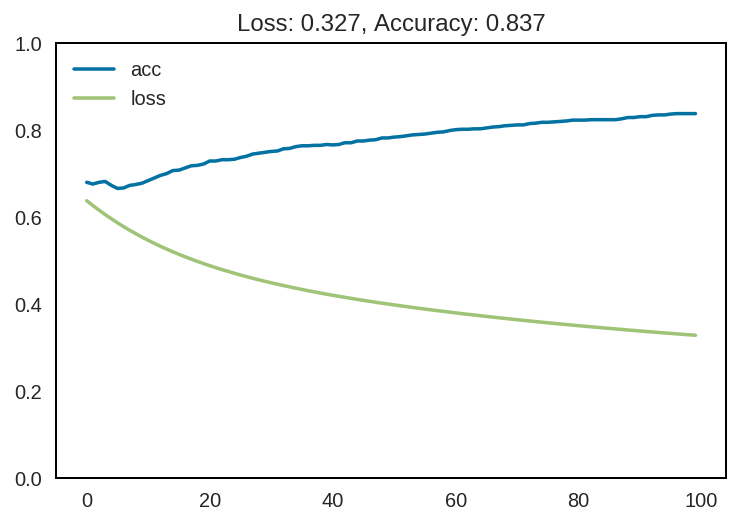

In [177]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile('adam','binary_crossentropy', metrics=['accuracy'])

history = model.fit(X,y, verbose=1, epochs=100)
plot_loss_accuracy(history)

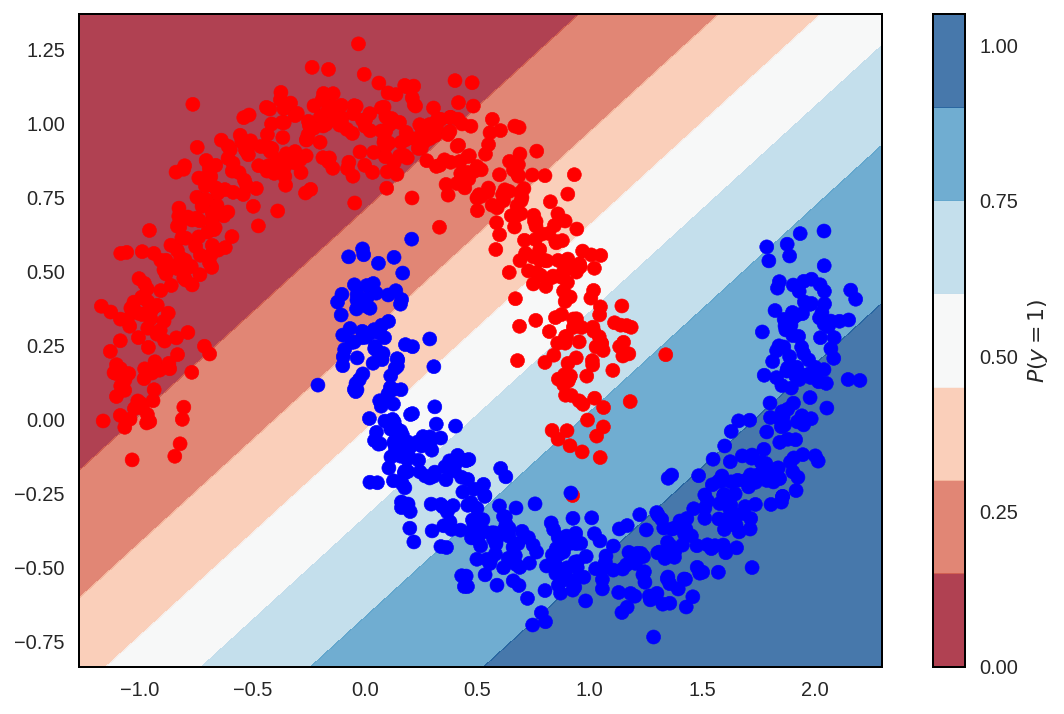

In [178]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

1000/1000 [==============================] - 0s 40us/step
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       500
          1       0.84      0.83      0.84       500

avg / total       0.84      0.84      0.84      1000



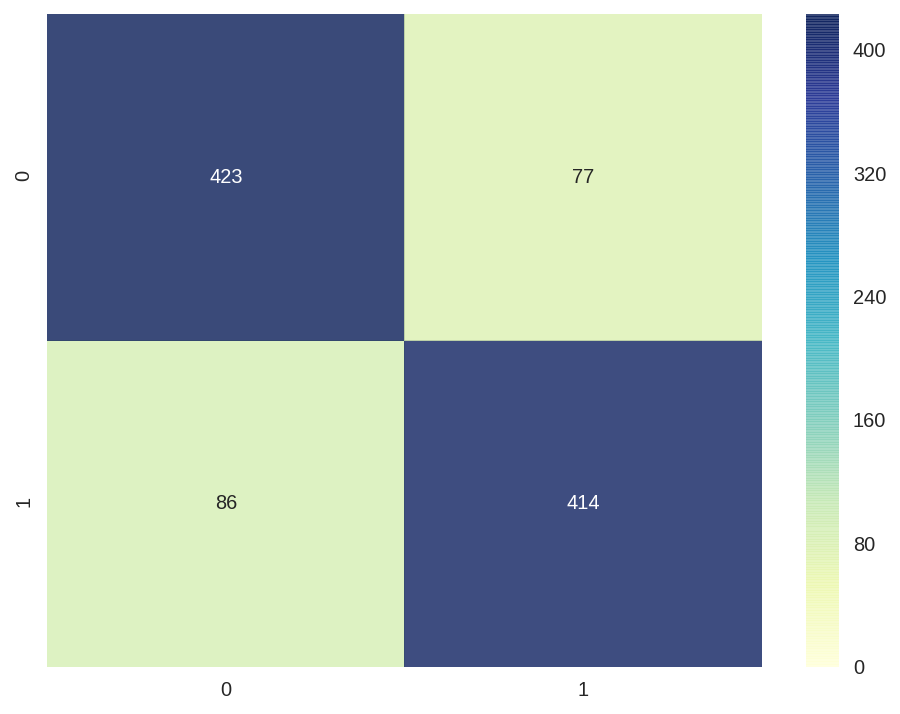

In [179]:
y_pred_1 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_1))
plot_confusion_matrix(model, X, y)

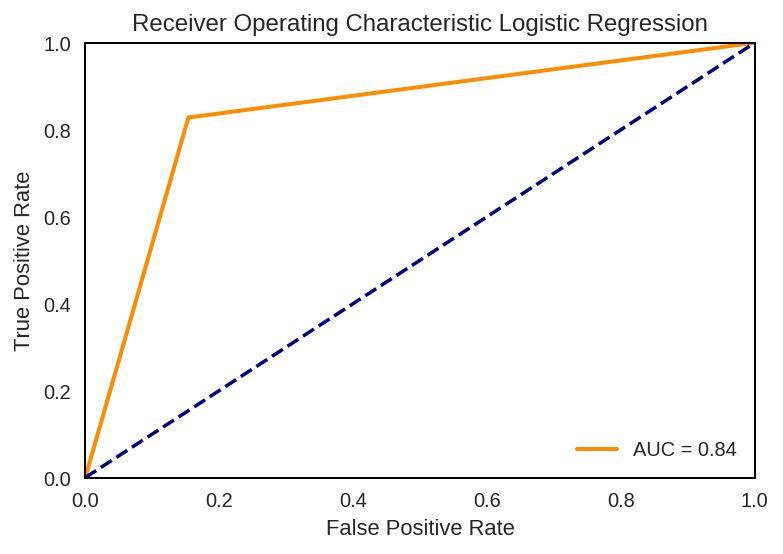

In [180]:
fpr_1, tpr_1, _= roc_curve(y,y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# method I: plt
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.plot(fpr_1, tpr_1, 'darkorange',lw=2, label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine

In [181]:
clf = svm.SVC(C=5,kernel='rbf',gamma=1)
clf.fit(X,y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

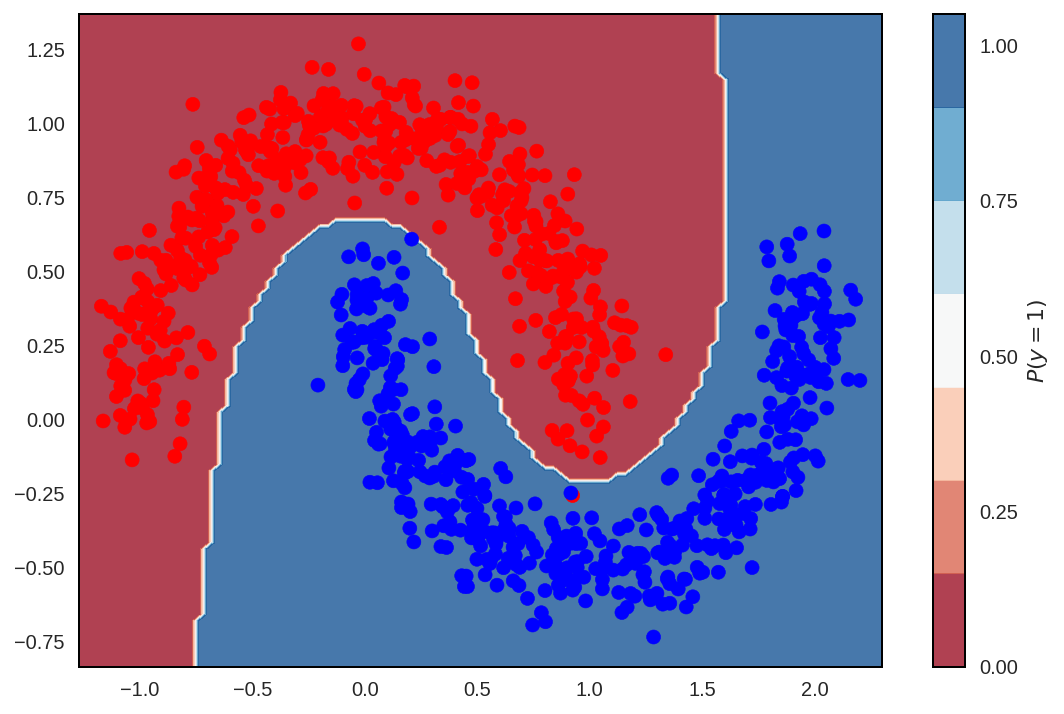

In [182]:
plot_decision_boundary(lambda x: clf.predict(x), X, y)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



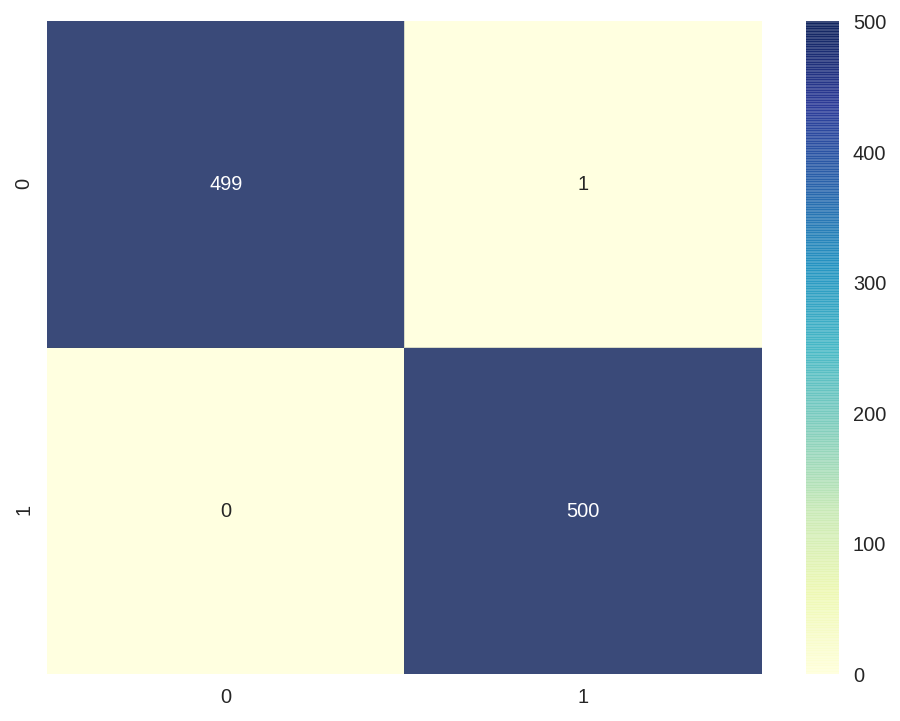

In [183]:
y_pred_2 = clf.predict(X)
print(classification_report(y, y_pred_2))
plot_confusion(clf, X, y)

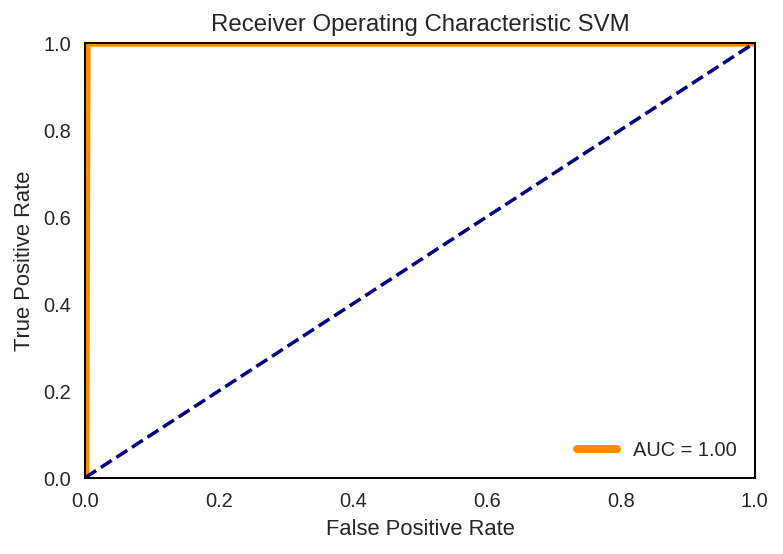

In [184]:
fpr_2, tpr_2, _= roc_curve(y,y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# method I: plt
plt.title('Receiver Operating Characteristic SVM')
plt.plot(fpr_2, tpr_2, 'darkorange',lw=4, label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network

### shallow NN

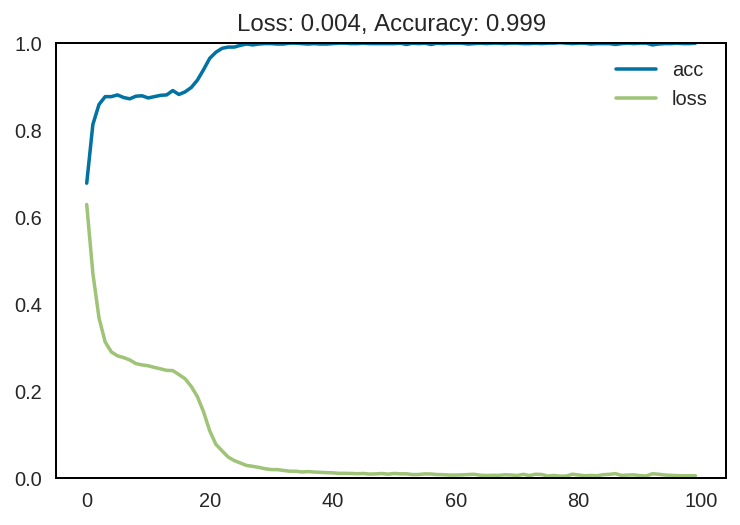

In [185]:
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

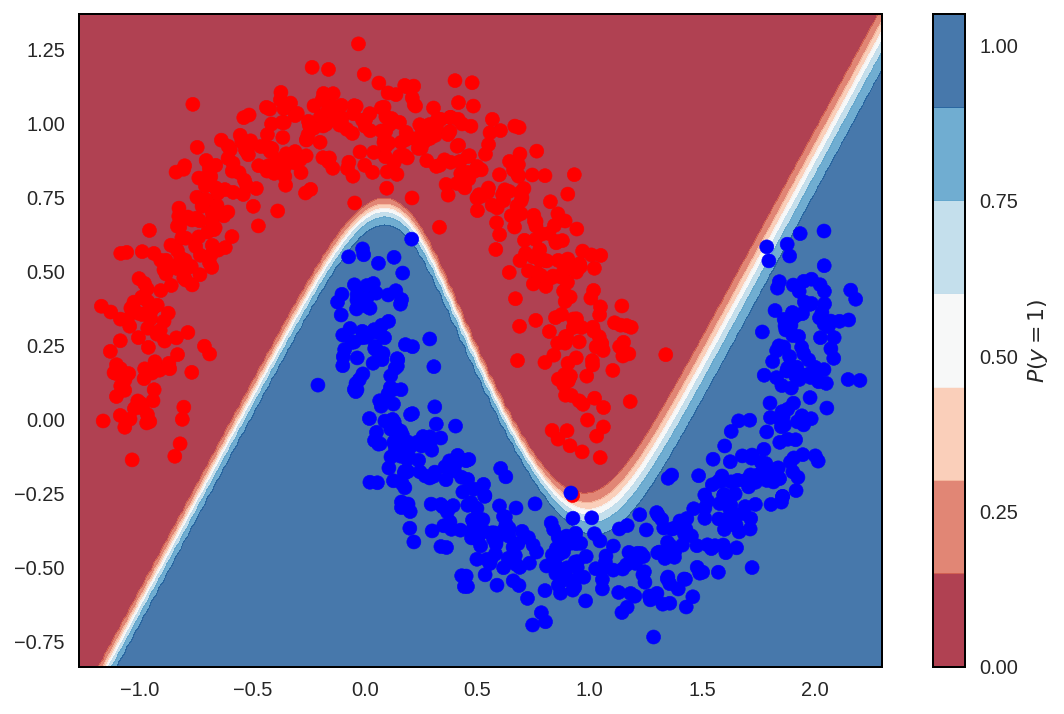

In [186]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

1000/1000 [==============================] - 0s 53us/step
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



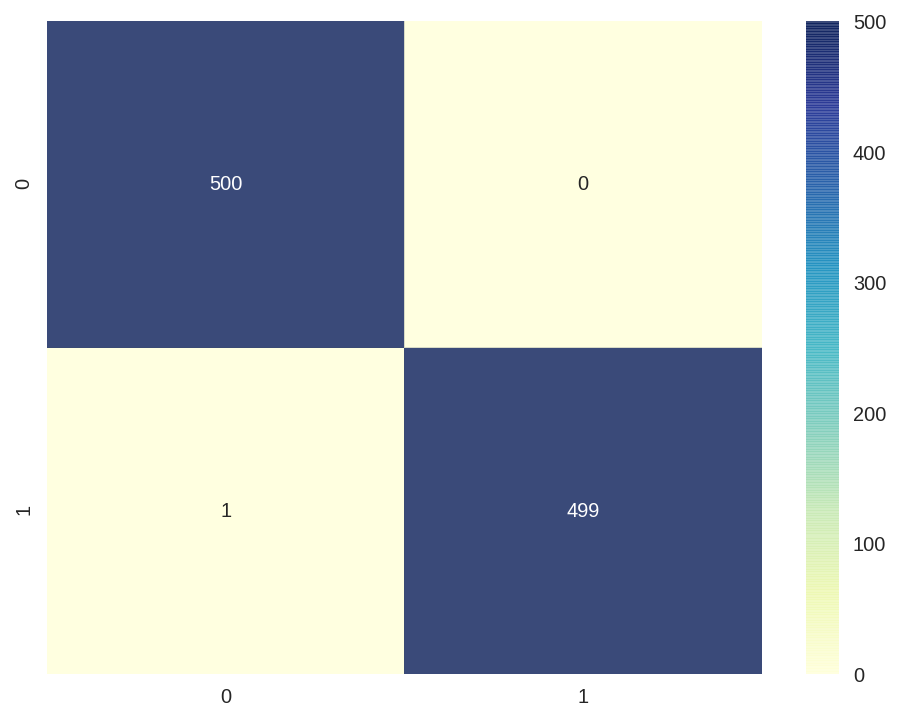

In [187]:
y_pred_3 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_3))
plot_confusion_matrix(model, X, y)

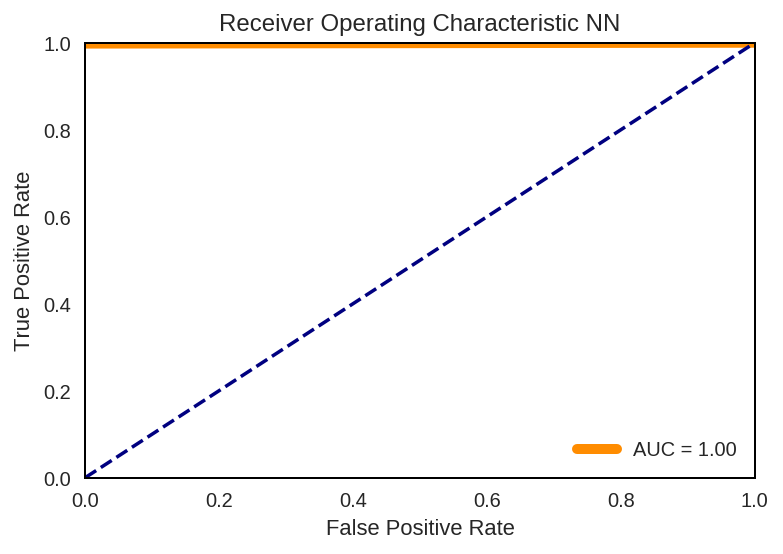

In [188]:
fpr_3, tpr_3, _= roc_curve(y,y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# method I: plt
plt.title('Receiver Operating Characteristic NN')
plt.plot(fpr_3, tpr_3, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Deep NN

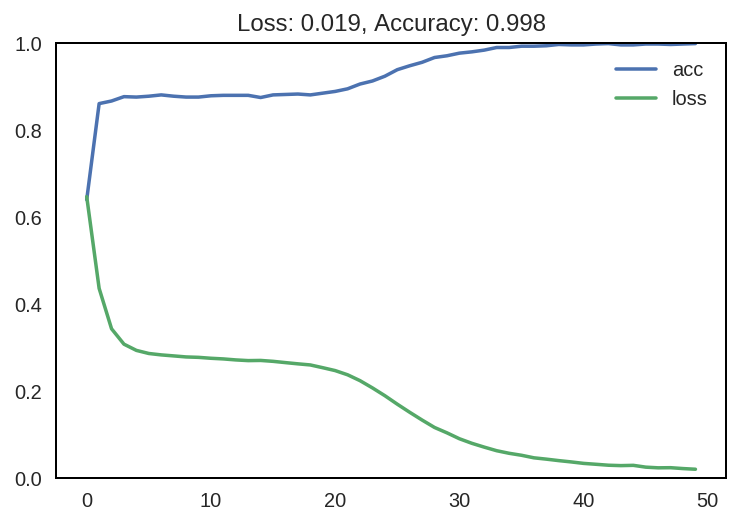

In [52]:
model = Sequential()

model.add(Dense(32, input_shape=(2,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y,verbose=0, epochs=50)

plot_loss_accuracy(history)

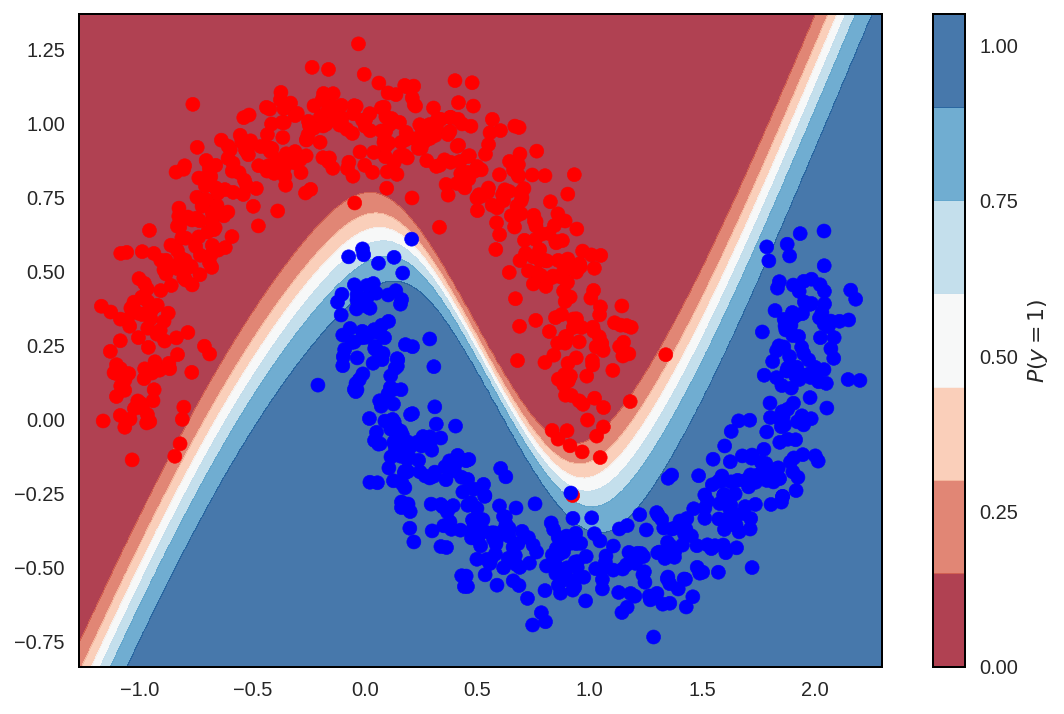

In [53]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

1000/1000 [==============================] - 0s 45us/step
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



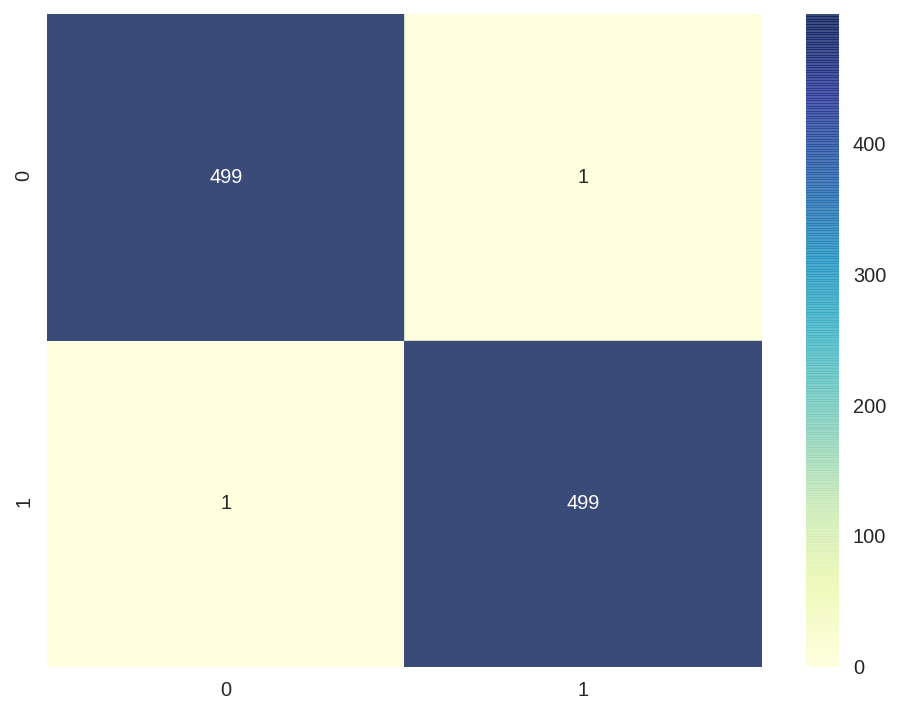

In [54]:
y_pred_4 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_4))
plot_confusion_matrix(model, X, y)

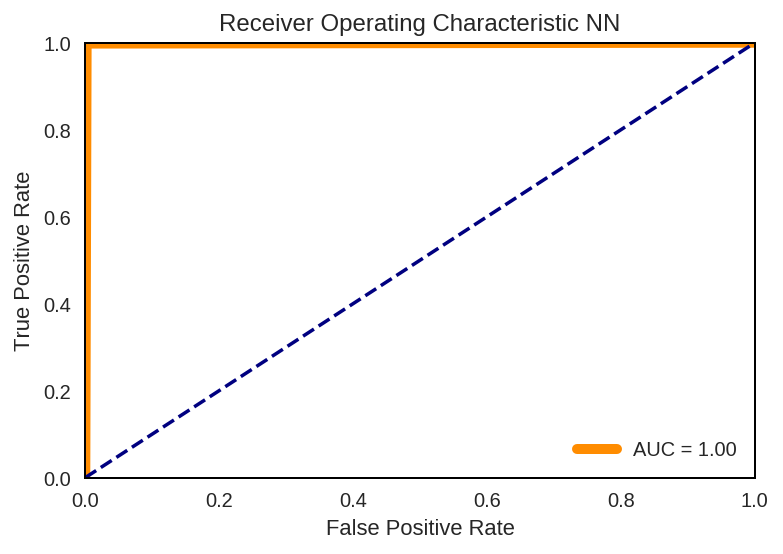

In [55]:
fpr_4, tpr_4, _= roc_curve(y,y_pred_4)
roc_auc_4 = auc(fpr_4, tpr_4)

# method I: plt
plt.title('Receiver Operating Characteristic NN')
plt.plot(fpr_4, tpr_4, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 3 Complex Data - Circles


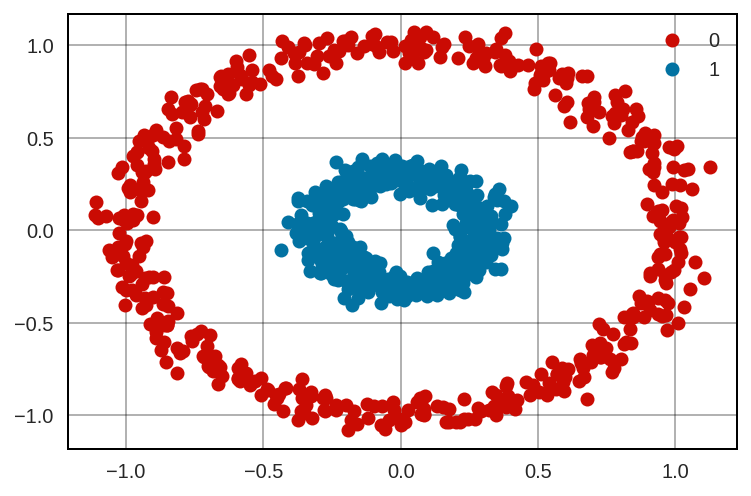

In [189]:
X,y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X,y)

## Logistic Regression

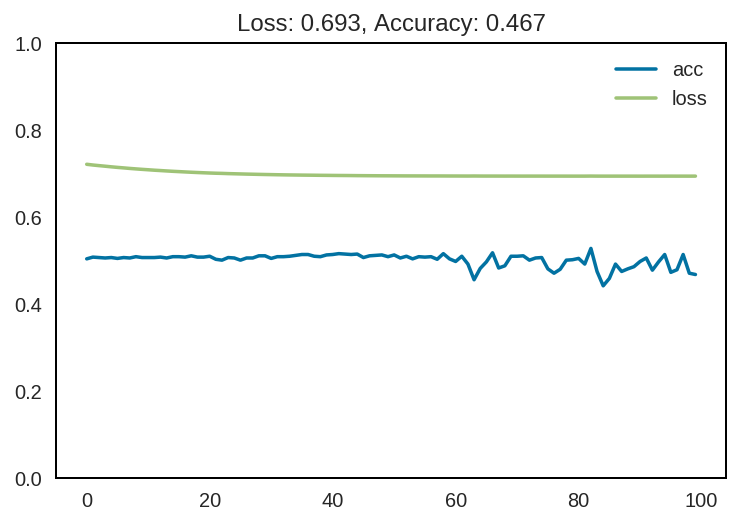

In [190]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile('adam','binary_crossentropy', metrics=['accuracy'])

history = model.fit(X,y, verbose=0, epochs=100)
plot_loss_accuracy(history)

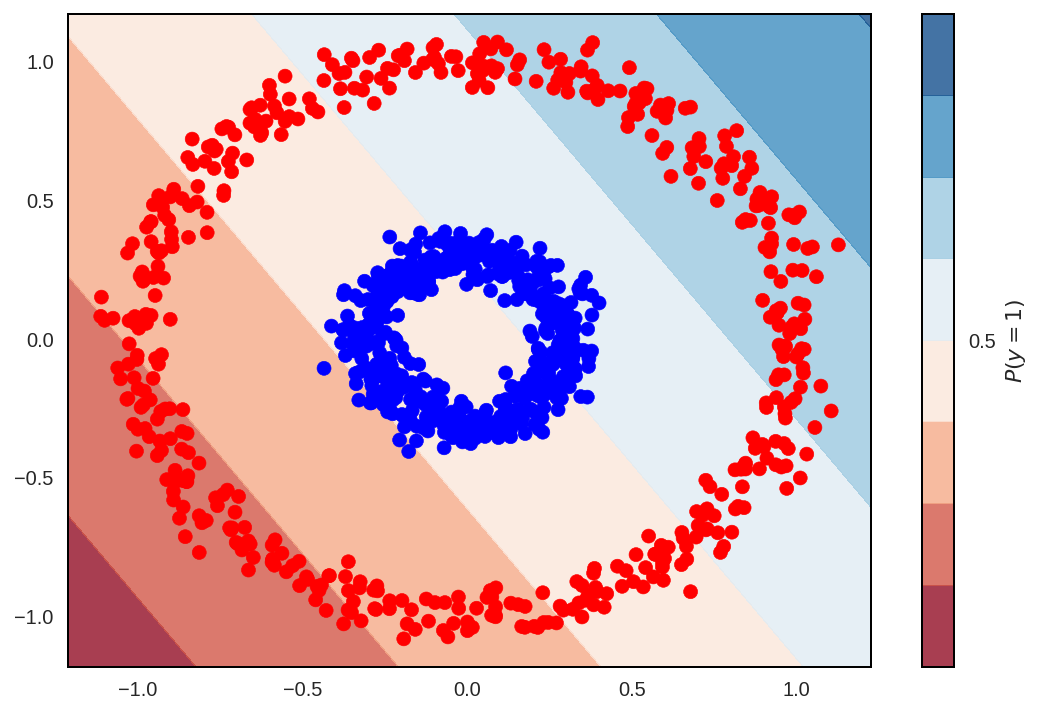

In [191]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

1000/1000 [==============================] - 0s 63us/step
             precision    recall  f1-score   support

          0       0.46      0.55      0.50       500
          1       0.43      0.34      0.38       500

avg / total       0.44      0.45      0.44      1000



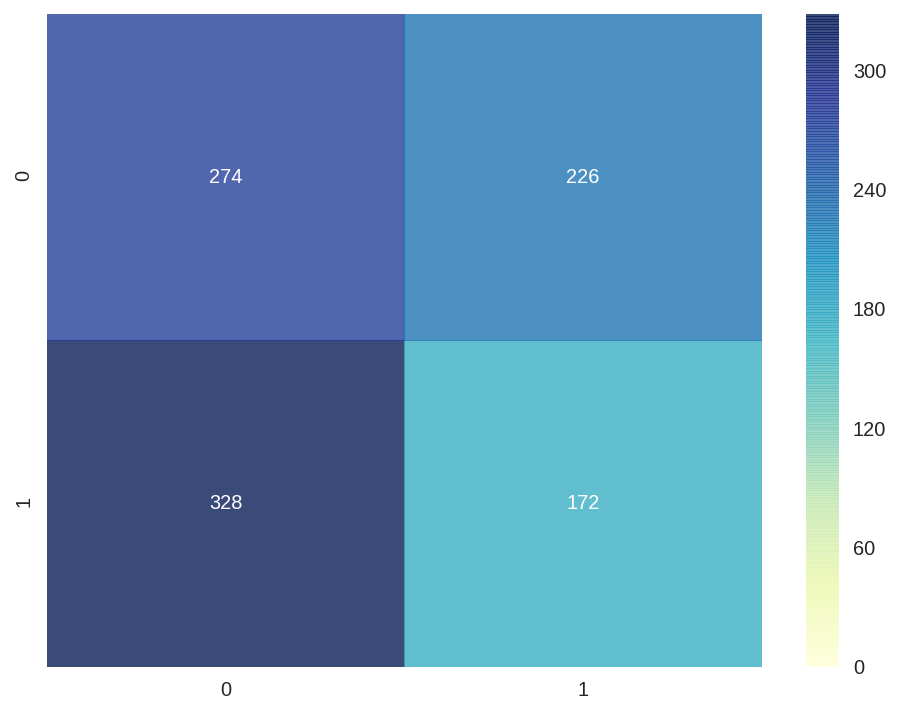

In [192]:
y_pred_1 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_1))
plot_confusion_matrix(model, X, y)

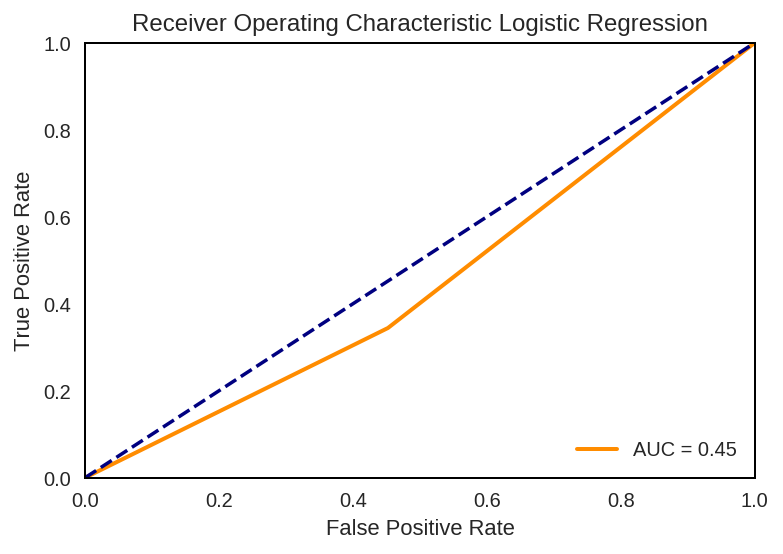

In [193]:
fpr_1, tpr_1, _= roc_curve(y,y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# method I: plt
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.plot(fpr_1, tpr_1, 'darkorange',lw=2, label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine

In [194]:
clf = svm.SVC(C=5,kernel='rbf',gamma=1)
clf.fit(X,y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

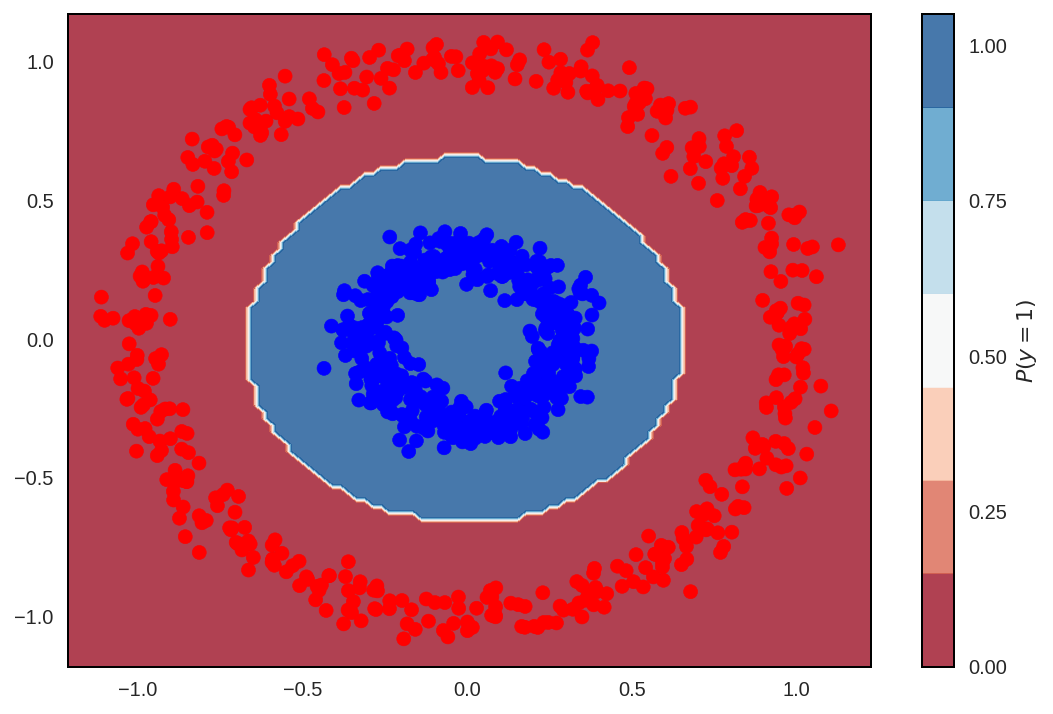

In [195]:
plot_decision_boundary(lambda x: clf.predict(x), X, y)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



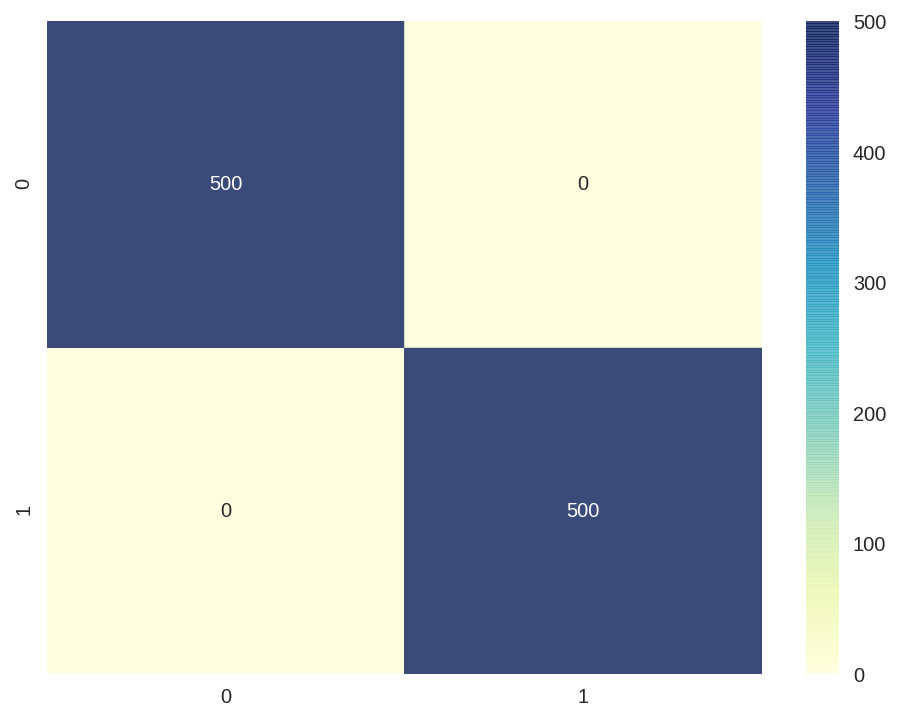

In [196]:
y_pred_2 = clf.predict(X)
print(classification_report(y, y_pred_2))
plot_confusion(clf, X, y)

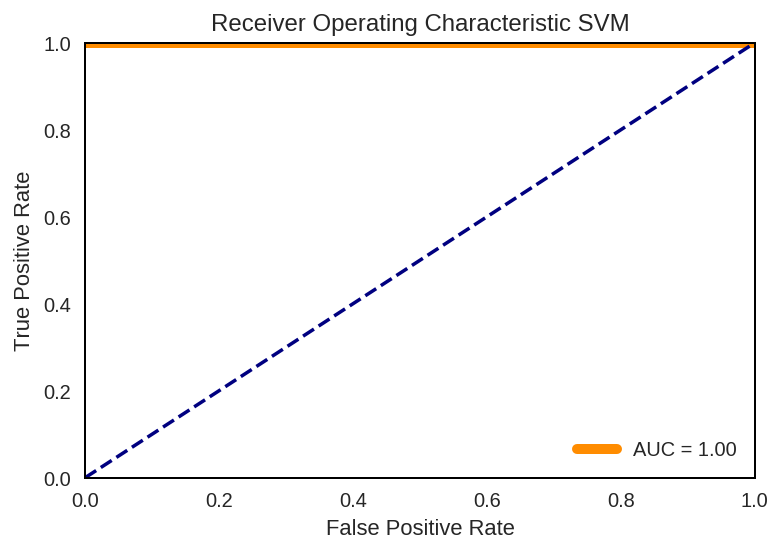

In [197]:
fpr_2, tpr_2, _= roc_curve(y,y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# method I: plt
plt.title('Receiver Operating Characteristic SVM')
plt.plot(fpr_2, tpr_2, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network

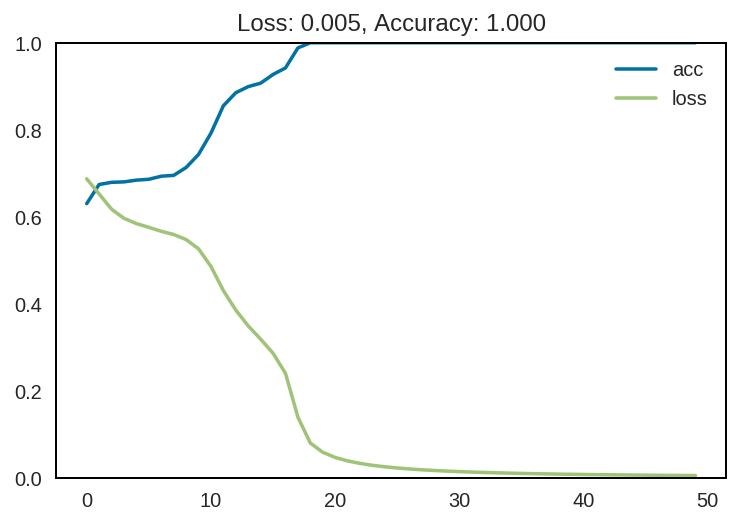

In [198]:
model = Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='tanh'))
model.add(Dense(units=2, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

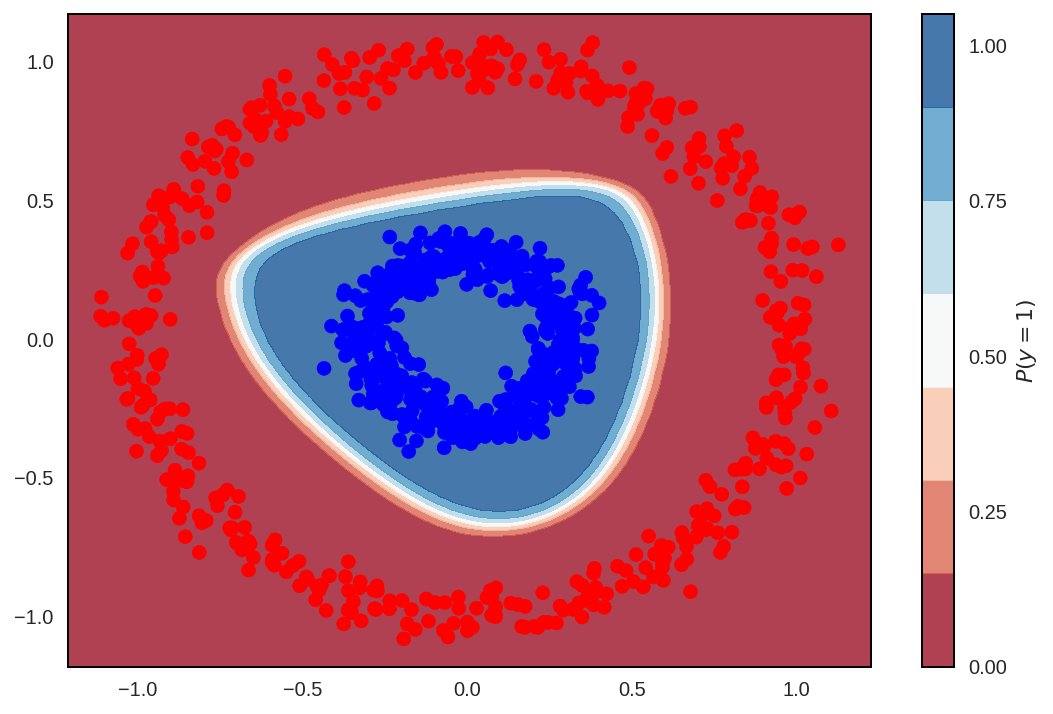

In [199]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

1000/1000 [==============================] - 0s 62us/step
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



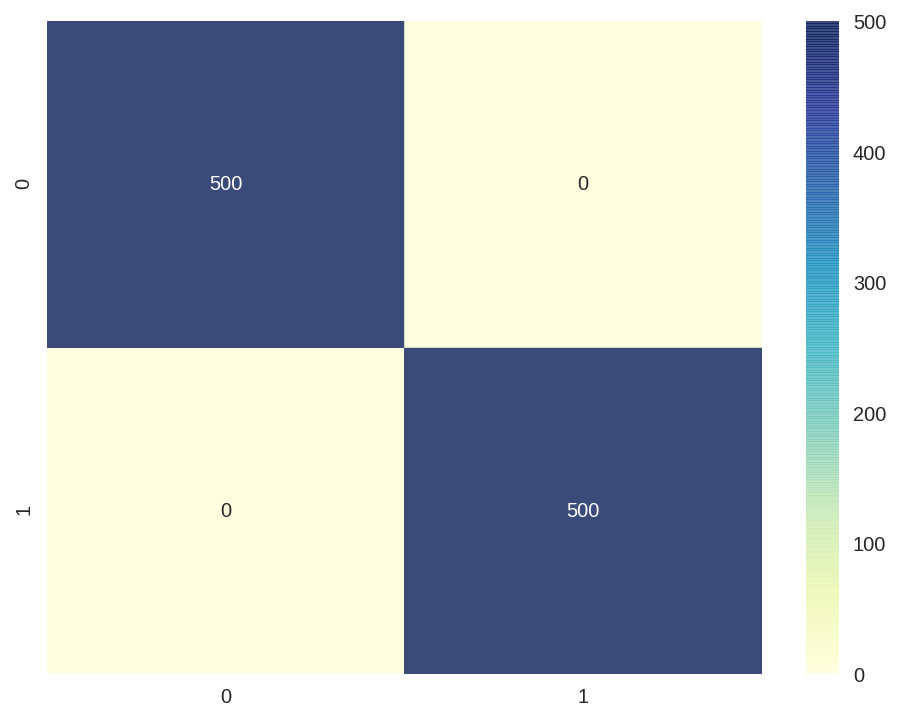

In [200]:
y_pred_3 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_3))
plot_confusion_matrix(model, X, y)

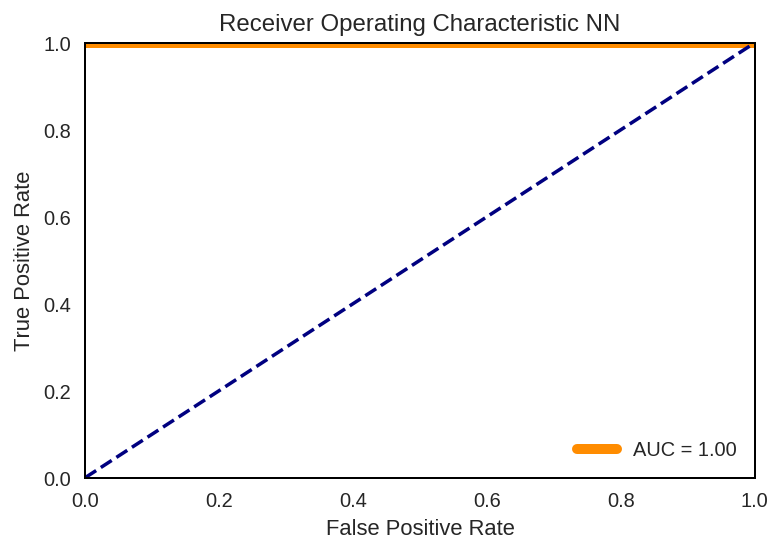

In [201]:
fpr_3, tpr_3, _= roc_curve(y,y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# method I: plt
plt.title('Receiver Operating Characteristic NN')
plt.plot(fpr_3, tpr_3, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#4.  Complex Data - Sine Wave





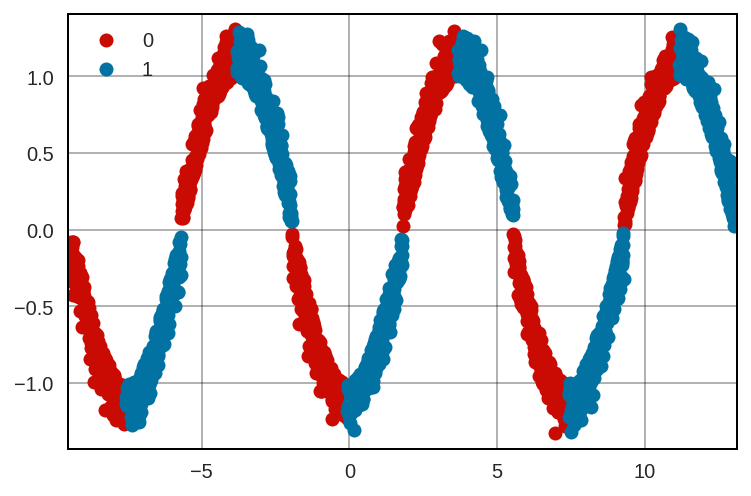

In [202]:
X, y = make_sine_wave()

plot_data(X, y, figsize=(10,8))

## Logistic Regression

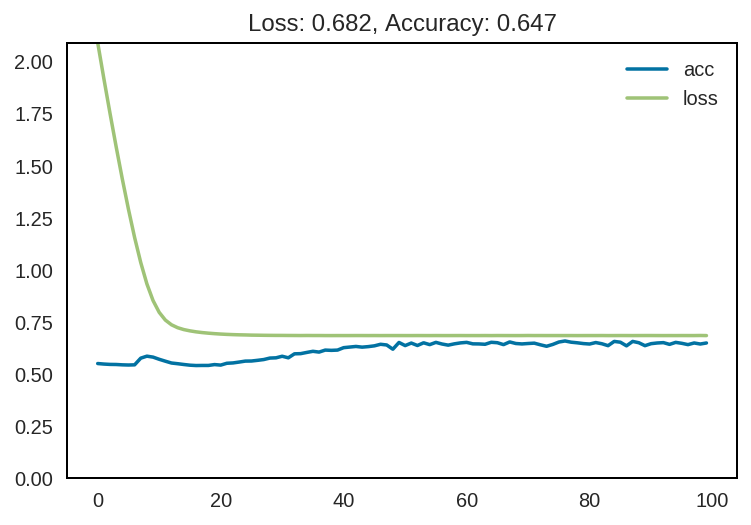

In [203]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile('adam','binary_crossentropy', metrics=['accuracy'])

history = model.fit(X,y, verbose=0, epochs=100)
plot_loss_accuracy(history)

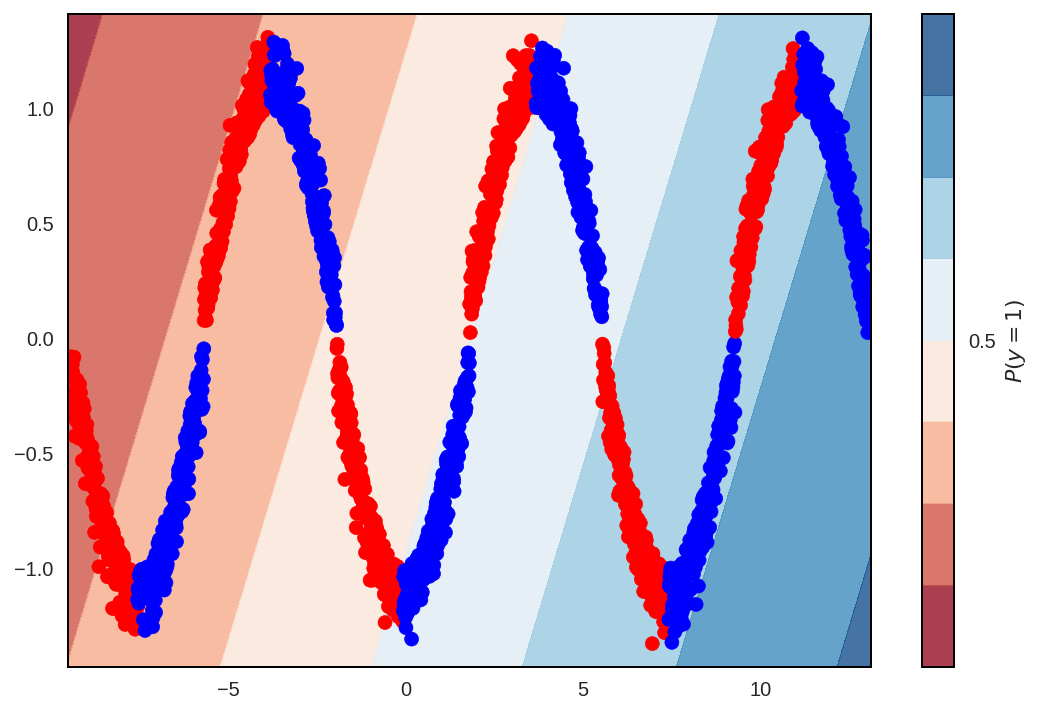

In [204]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

2400/2400 [==============================] - 0s 41us/step
             precision    recall  f1-score   support

      False       0.64      0.65      0.65      1200
       True       0.65      0.64      0.64      1200

avg / total       0.64      0.64      0.64      2400



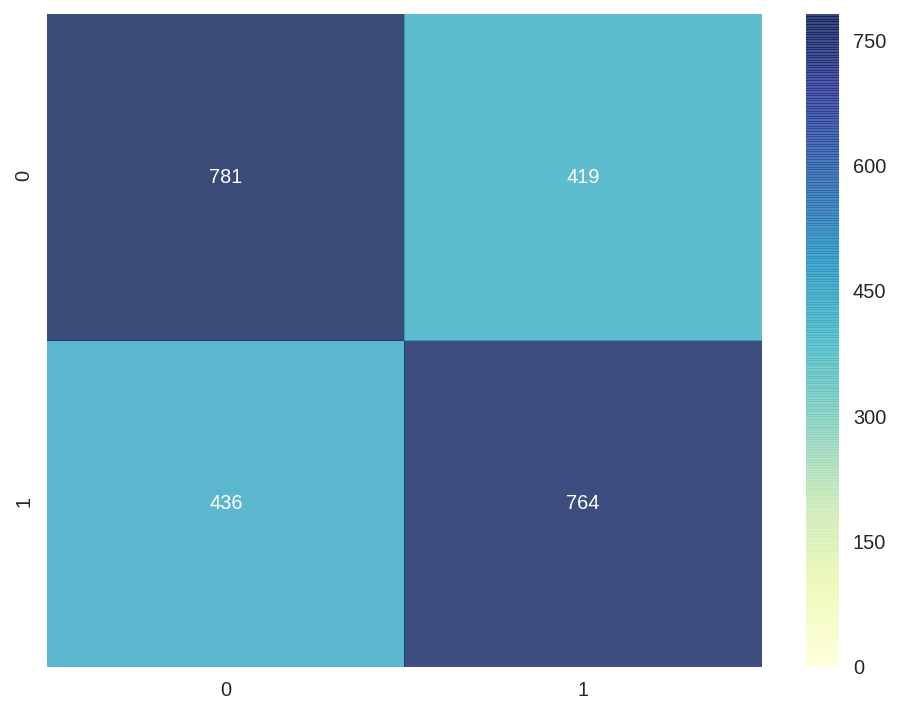

In [205]:
y_pred_1 = model.predict_classes(X, verbose=1)
print(classification_report(y, y_pred_1))
plot_confusion_matrix(model, X, y)

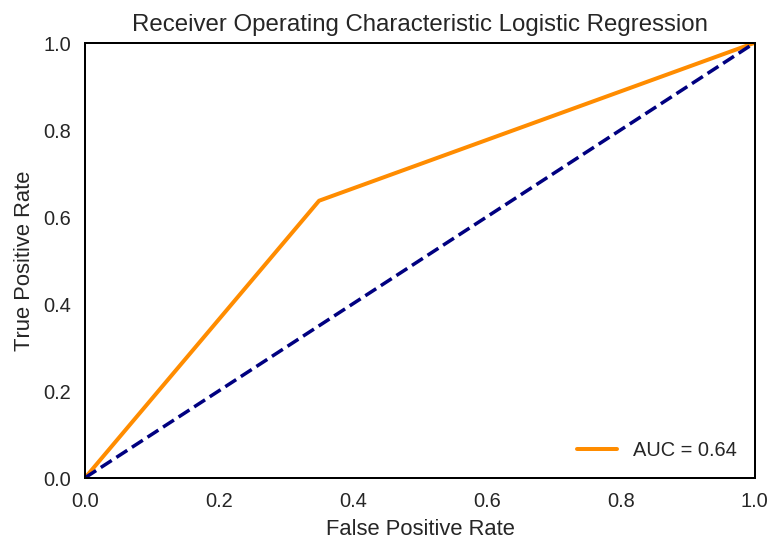

In [206]:
fpr_1, tpr_1, _= roc_curve(y,y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)

# method I: plt
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.plot(fpr_1, tpr_1, 'darkorange',lw=2, label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine

In [207]:
# support vector machine
clf = svm.SVC(C=1,kernel='rbf',gamma=5)
clf.fit(X,y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

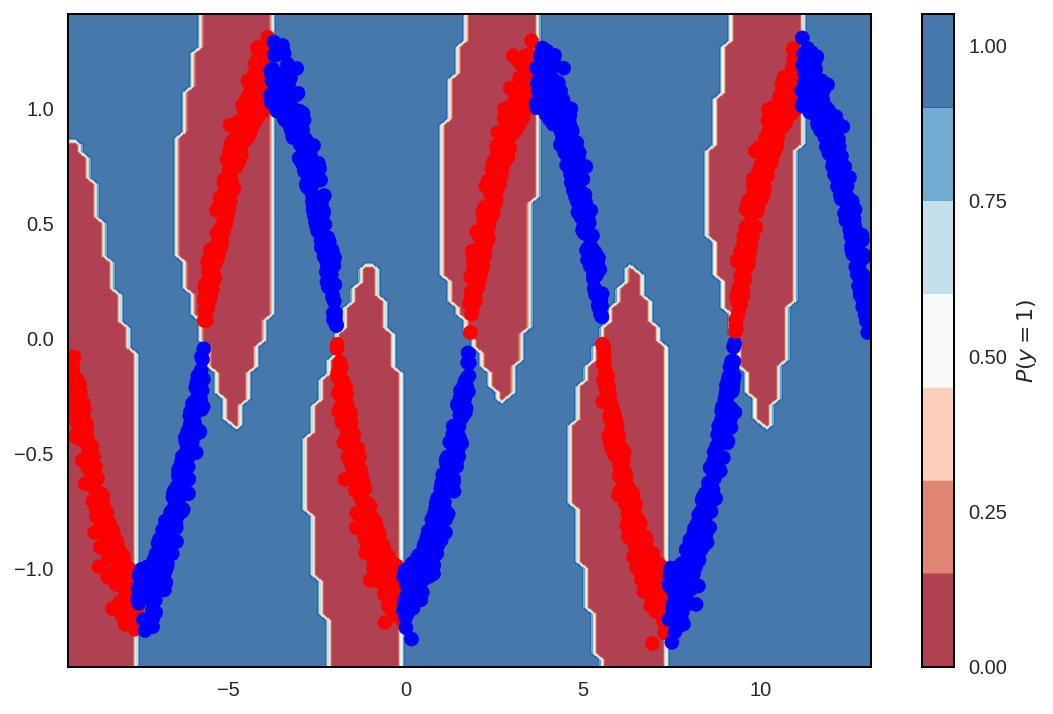

In [208]:
plot_decision_boundary(lambda x: clf.predict(x), X, y)

             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1200
       True       1.00      1.00      1.00      1200

avg / total       1.00      1.00      1.00      2400



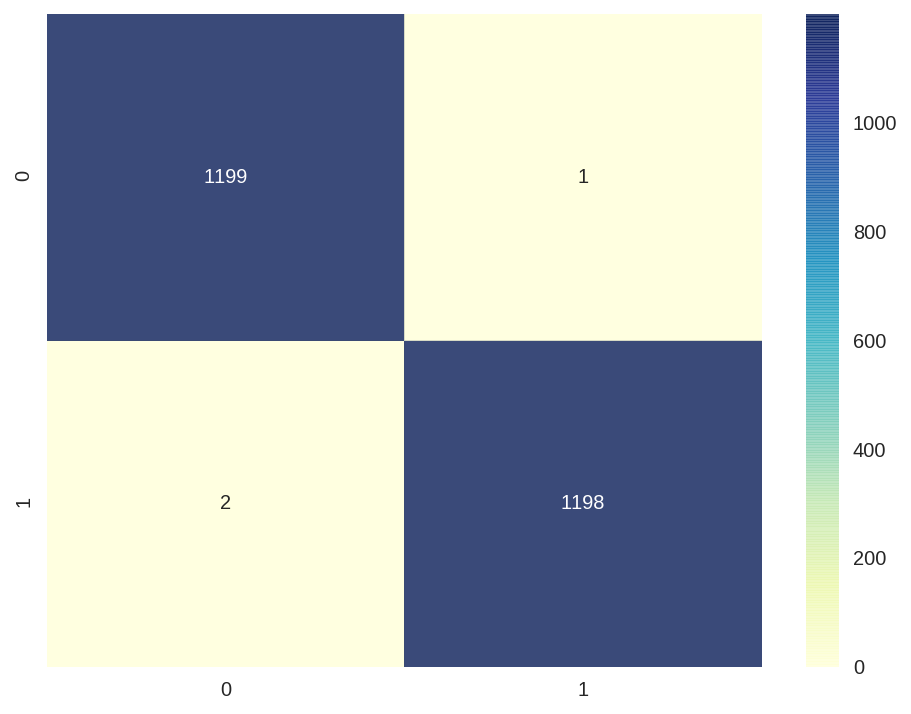

In [209]:
y_pred_2 = clf.predict(X)
print(classification_report(y, y_pred_2))
plot_confusion(clf, X, y)

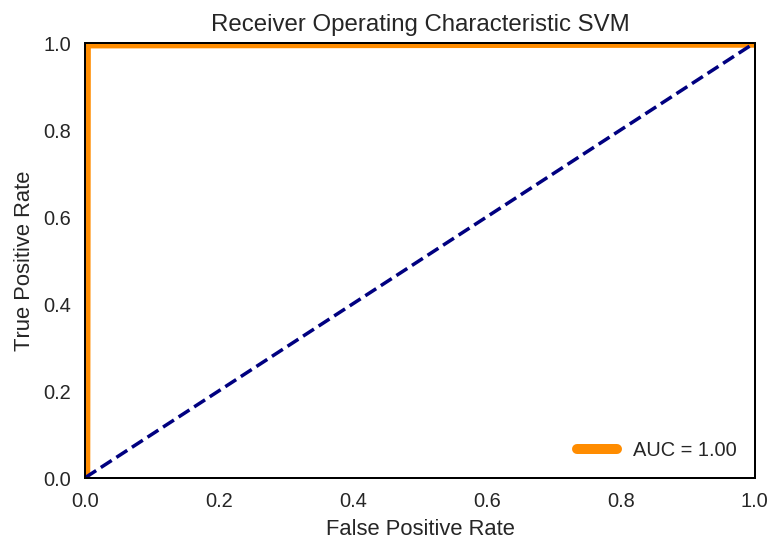

In [210]:
fpr_2, tpr_2, _= roc_curve(y,y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)

# method I: plt
plt.title('Receiver Operating Characteristic SVM')
plt.plot(fpr_2, tpr_2, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network

### shalow NN

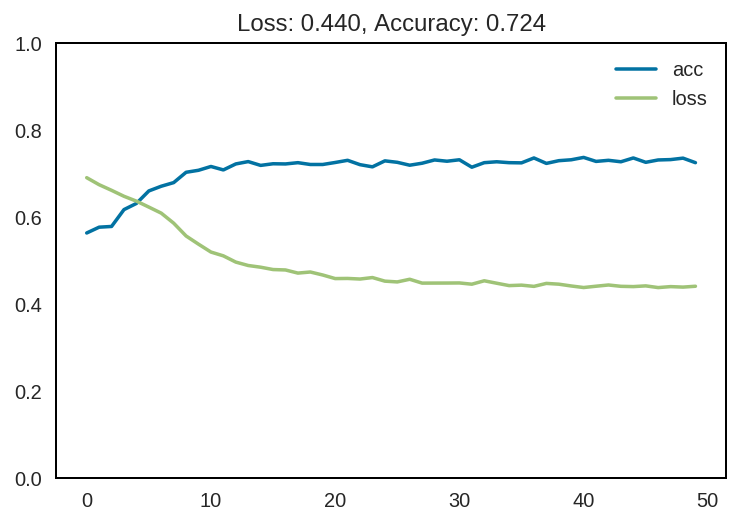

In [215]:
model = Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='tanh'))
model.add(Dense(units=2, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

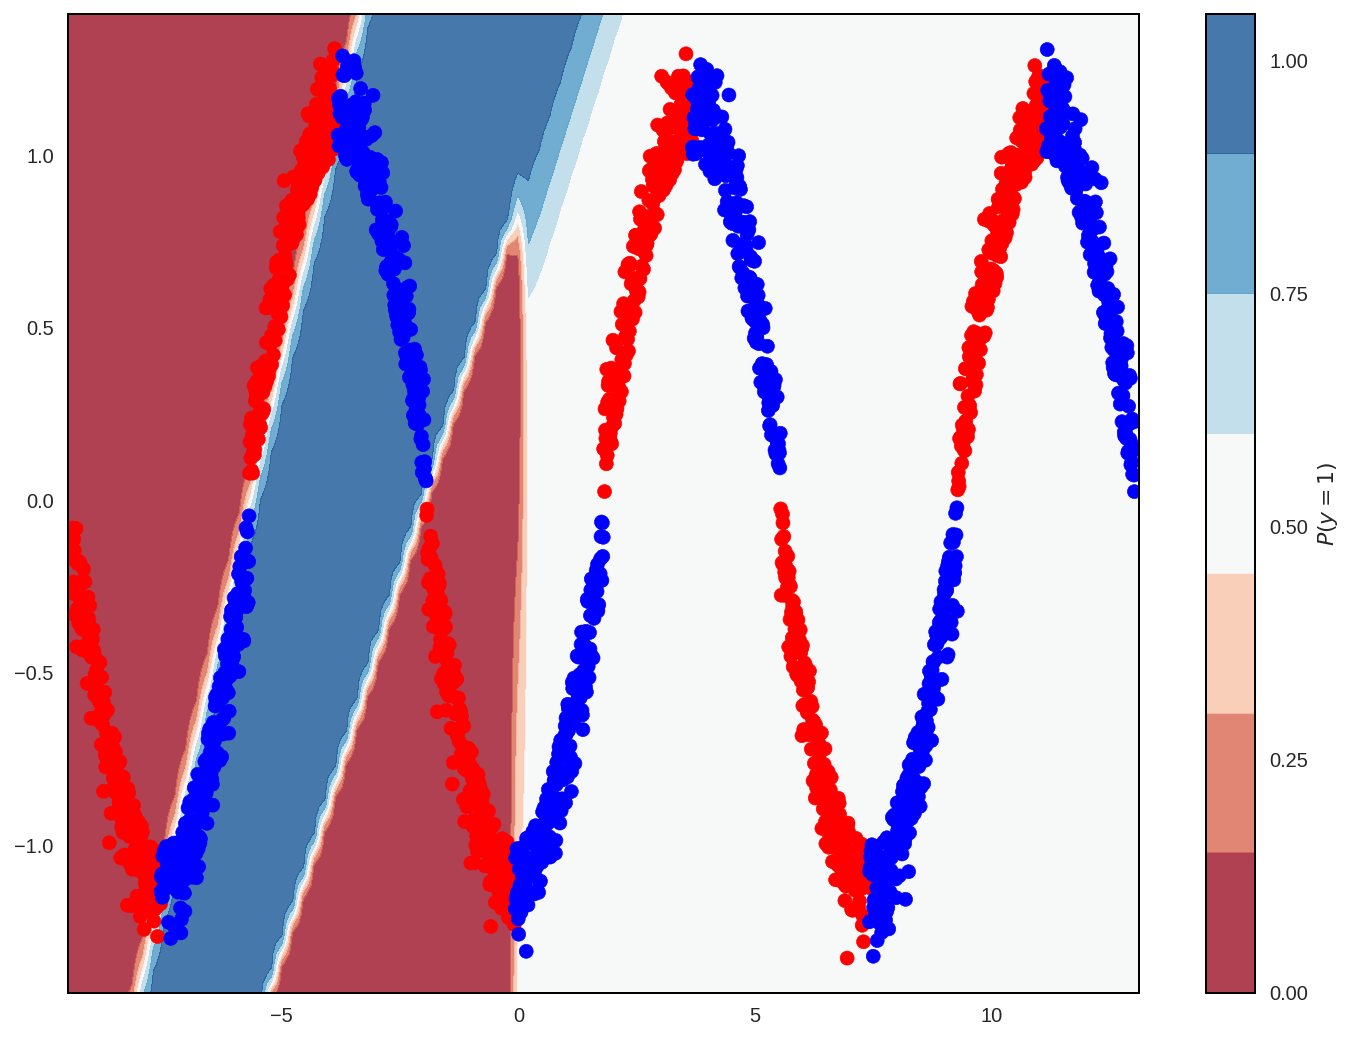

In [216]:
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12,9))

             precision    recall  f1-score   support

      False       0.69      0.66      0.67      1200
       True       0.67      0.71      0.69      1200

avg / total       0.68      0.68      0.68      2400



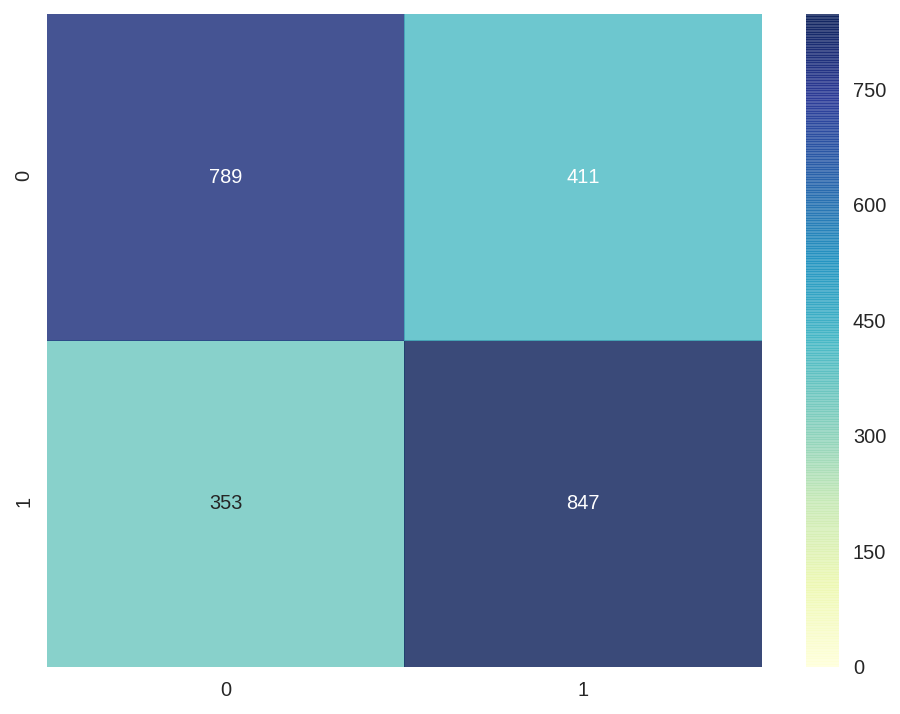

In [217]:
y_pred_3 = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred_3))
plot_confusion_matrix(model, X, y )

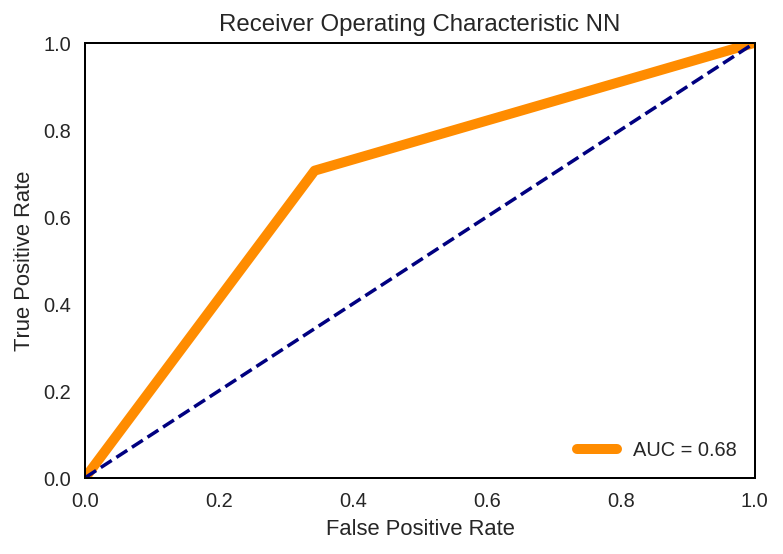

In [218]:
fpr_3, tpr_3, _= roc_curve(y,y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# method I: plt
plt.title('Receiver Operating Characteristic NN')
plt.plot(fpr_3, tpr_3, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Deep NN

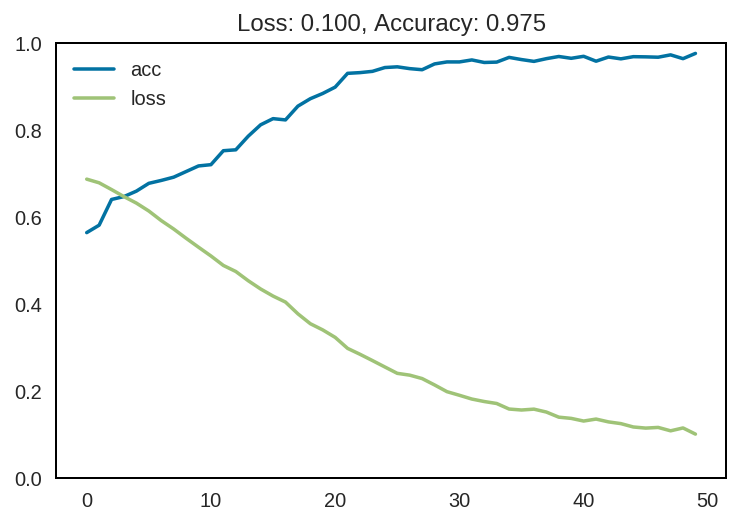

In [211]:
model = Sequential()

model.add(Dense(32, input_shape=(2,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y,verbose=0, epochs=50)

plot_loss_accuracy(history)

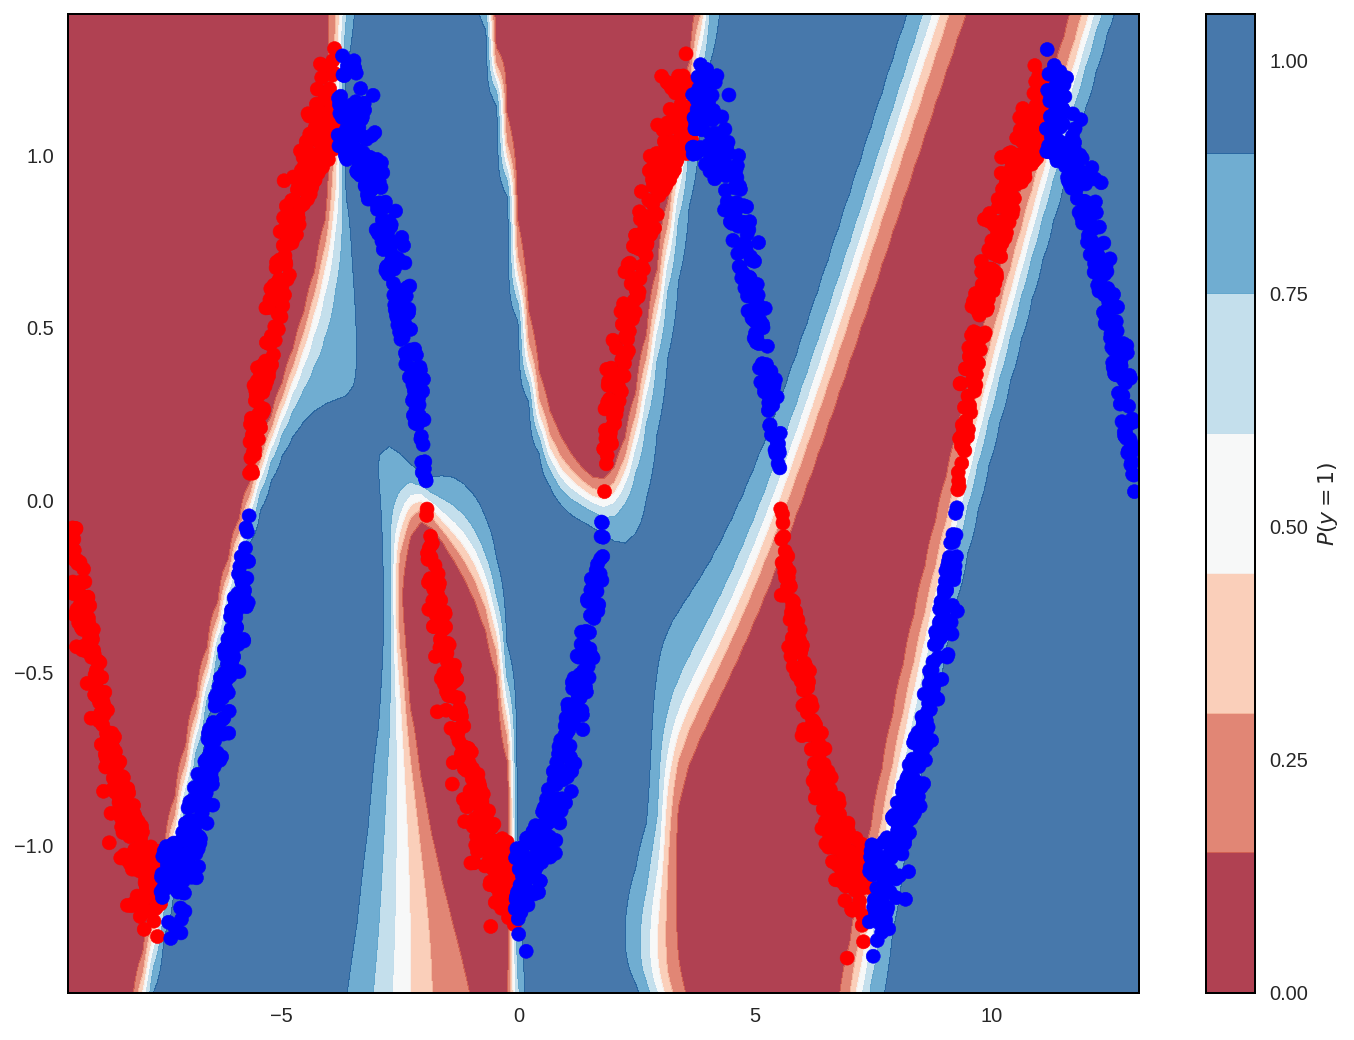

In [212]:
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12,9))

             precision    recall  f1-score   support

      False       0.95      0.99      0.97      1200
       True       0.99      0.94      0.97      1200

avg / total       0.97      0.97      0.97      2400



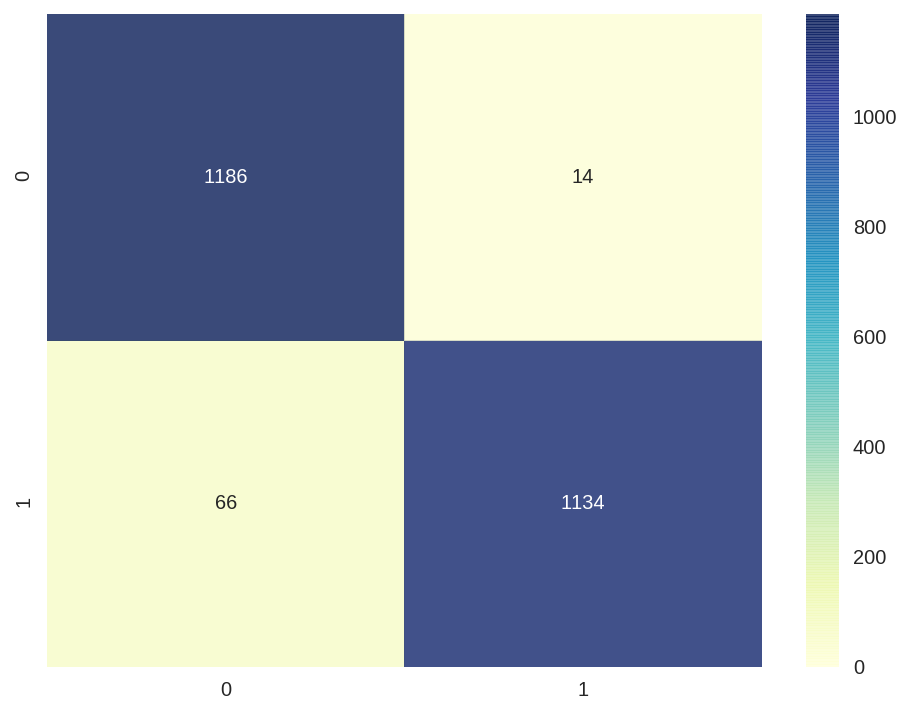

In [213]:
y_pred_3 = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred_3))
plot_confusion_matrix(model, X, y )

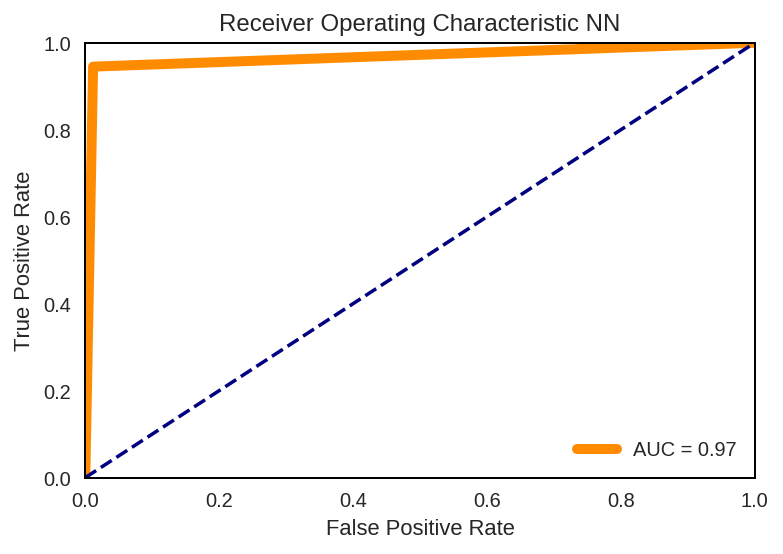

In [214]:
fpr_3, tpr_3, _= roc_curve(y,y_pred_3)
roc_auc_3 = auc(fpr_3, tpr_3)

# method I: plt
plt.title('Receiver Operating Characteristic NN')
plt.plot(fpr_3, tpr_3, 'darkorange',lw=5, label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 5. Multiclass Complex Data

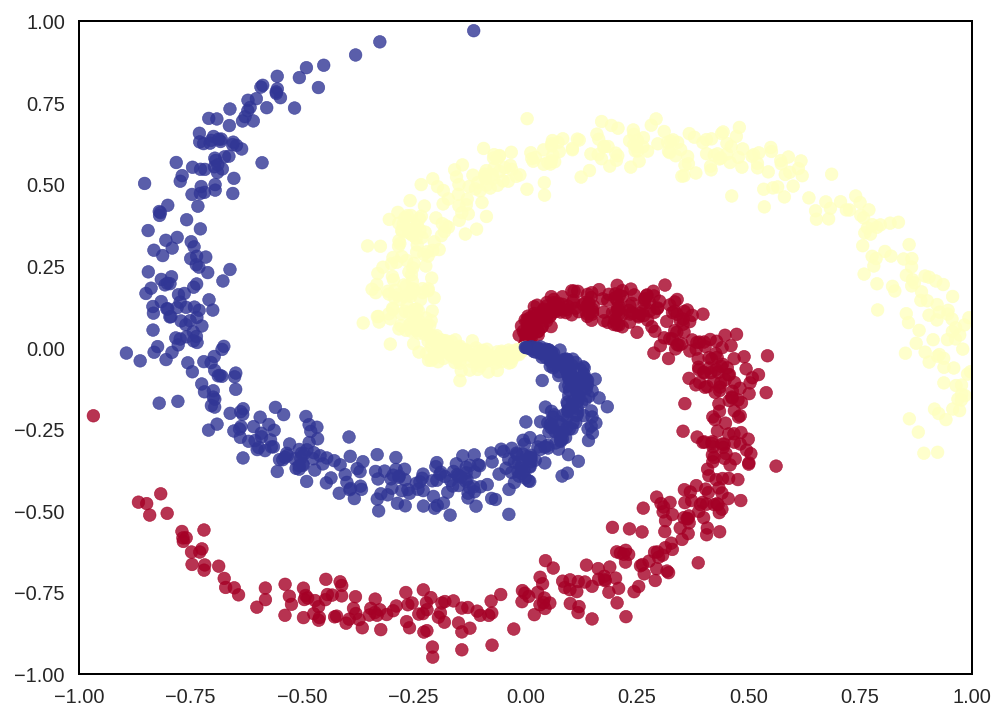

In [60]:
X, y = make_multiclass(K=3)

## Logistic Regression

Epoch 1/100
1500/1500 [==============================] - 1s 378us/step - loss: 0.6099 - acc: 0.4280
Epoch 2/100
1500/1500 [==============================] - 0s 149us/step - loss: 0.5811 - acc: 0.4120
Epoch 3/100
1500/1500 [==============================] - 0s 161us/step - loss: 0.5529 - acc: 0.4000
Epoch 4/100
1500/1500 [==============================] - 0s 155us/step - loss: 0.5258 - acc: 0.3900
Epoch 5/100
1500/1500 [==============================] - 0s 144us/step - loss: 0.4995 - acc: 0.3887
Epoch 6/100
1500/1500 [==============================] - 0s 143us/step - loss: 0.4741 - acc: 0.3807
Epoch 7/100
1500/1500 [==============================] - 0s 160us/step - loss: 0.4494 - acc: 0.3780
Epoch 8/100
1500/1500 [==============================] - 0s 156us/step - loss: 0.4254 - acc: 0.3707
Epoch 9/100
1500/1500 [==============================] - 0s 174us/step - loss: 0.4021 - acc: 0.3653
Epoch 10/100
1500/1500 [==============================] - 0s 169us/step - loss: 0.3797 - acc: 0.3547

1500/1500 [==============================] - 0s 174us/step - loss: 0.2205 - acc: 0.3100
Epoch 19/100
1500/1500 [==============================] - 0s 173us/step - loss: 0.2030 - acc: 0.3093
Epoch 20/100
1500/1500 [==============================] - 0s 172us/step - loss: 0.1857 - acc: 0.3053
Epoch 21/100
1500/1500 [==============================] - 0s 172us/step - loss: 0.1690 - acc: 0.3027
Epoch 22/100
1500/1500 [==============================] - 0s 172us/step - loss: 0.1526 - acc: 0.3013
Epoch 23/100
1500/1500 [==============================] - 0s 175us/step - loss: 0.1365 - acc: 0.3020
Epoch 24/100
1500/1500 [==============================] - 0s 168us/step - loss: 0.1209 - acc: 0.3020
Epoch 25/100
1500/1500 [==============================] - 0s 168us/step - loss: 0.1056 - acc: 0.3027
Epoch 26/100
1500/1500 [==============================] - 0s 176us/step - loss: 0.0906 - acc: 0.2993
Epoch 27/100
1500/1500 [==============================] - 0s 166us/step - loss: 0.0758 - acc: 0.3000
Epo

1500/1500 [==============================] - 0s 170us/step - loss: -0.0200 - acc: 0.2987
Epoch 35/100
1500/1500 [==============================] - 0s 170us/step - loss: -0.0327 - acc: 0.2980
Epoch 36/100
1500/1500 [==============================] - 0s 165us/step - loss: -0.0453 - acc: 0.2987
Epoch 37/100
1500/1500 [==============================] - 0s 162us/step - loss: -0.0577 - acc: 0.2993
Epoch 38/100
1500/1500 [==============================] - 0s 165us/step - loss: -0.0698 - acc: 0.3000
Epoch 39/100
1500/1500 [==============================] - 0s 171us/step - loss: -0.0820 - acc: 0.3007
Epoch 40/100
1500/1500 [==============================] - 0s 172us/step - loss: -0.0938 - acc: 0.3000
Epoch 41/100
1500/1500 [==============================] - 0s 175us/step - loss: -0.1055 - acc: 0.2987
Epoch 42/100
1500/1500 [==============================] - 0s 174us/step - loss: -0.1171 - acc: 0.2987
Epoch 43/100
1500/1500 [==============================] - 0s 170us/step - loss: -0.1285 - acc: 

1500/1500 [==============================] - 0s 162us/step - loss: -0.2050 - acc: 0.3000
Epoch 51/100
1500/1500 [==============================] - 0s 166us/step - loss: -0.2154 - acc: 0.3000
Epoch 52/100
1500/1500 [==============================] - 0s 157us/step - loss: -0.2257 - acc: 0.3000
Epoch 53/100
1500/1500 [==============================] - 0s 158us/step - loss: -0.2362 - acc: 0.3020
Epoch 54/100
1500/1500 [==============================] - 0s 158us/step - loss: -0.2462 - acc: 0.3020
Epoch 55/100
1500/1500 [==============================] - 0s 167us/step - loss: -0.2565 - acc: 0.3027
Epoch 56/100
1500/1500 [==============================] - 0s 166us/step - loss: -0.2665 - acc: 0.3033
Epoch 57/100
1500/1500 [==============================] - 0s 168us/step - loss: -0.2765 - acc: 0.3033
Epoch 58/100
1500/1500 [==============================] - 0s 181us/step - loss: -0.2863 - acc: 0.3040
Epoch 59/100
1500/1500 [==============================] - 0s 170us/step - loss: -0.2961 - acc: 

Epoch 67/100
1500/1500 [==============================] - 0s 168us/step - loss: -0.3725 - acc: 0.3060
Epoch 68/100
1500/1500 [==============================] - 0s 167us/step - loss: -0.3818 - acc: 0.3060
Epoch 69/100
1500/1500 [==============================] - 0s 162us/step - loss: -0.3910 - acc: 0.3060
Epoch 70/100
1500/1500 [==============================] - 0s 161us/step - loss: -0.4003 - acc: 0.3060
Epoch 71/100
1500/1500 [==============================] - 0s 155us/step - loss: -0.4094 - acc: 0.3060
Epoch 72/100
1500/1500 [==============================] - 0s 163us/step - loss: -0.4185 - acc: 0.3060
Epoch 73/100
1500/1500 [==============================] - 0s 155us/step - loss: -0.4275 - acc: 0.3060
Epoch 74/100
1500/1500 [==============================] - 0s 157us/step - loss: -0.4366 - acc: 0.3060
Epoch 75/100
1500/1500 [==============================] - 0s 160us/step - loss: -0.4456 - acc: 0.3067
Epoch 76/100
1500/1500 [==============================] - 0s 158us/step - loss: -0

1500/1500 [==============================] - 0s 161us/step - loss: -0.5247 - acc: 0.3087
Epoch 85/100
1500/1500 [==============================] - 0s 170us/step - loss: -0.5334 - acc: 0.3093
Epoch 86/100
1500/1500 [==============================] - 0s 177us/step - loss: -0.5419 - acc: 0.3107
Epoch 87/100
1500/1500 [==============================] - 0s 160us/step - loss: -0.5504 - acc: 0.3100
Epoch 88/100
1500/1500 [==============================] - 0s 162us/step - loss: -0.5591 - acc: 0.3120
Epoch 89/100
1500/1500 [==============================] - 0s 172us/step - loss: -0.5676 - acc: 0.3133
Epoch 90/100
1500/1500 [==============================] - 0s 173us/step - loss: -0.5760 - acc: 0.3133
Epoch 91/100
1500/1500 [==============================] - 0s 169us/step - loss: -0.5845 - acc: 0.3133
Epoch 92/100
1500/1500 [==============================] - 0s 173us/step - loss: -0.5929 - acc: 0.3133
Epoch 93/100
1500/1500 [==============================] - 0s 175us/step - loss: -0.6015 - acc: 

1500/1500 [==============================] - 0s 171us/step - loss: -0.6596 - acc: 0.3160


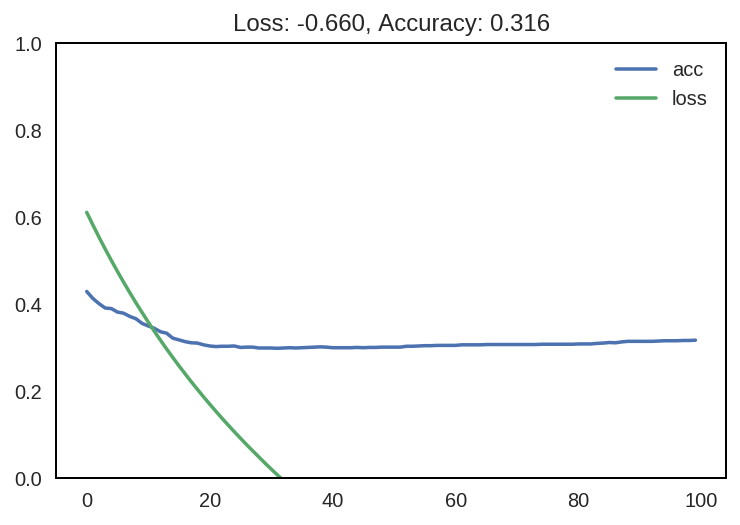

In [61]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile('adam','binary_crossentropy', metrics=['accuracy'])

history = model.fit(X,y, verbose=1, epochs=100)
plot_loss_accuracy(history)

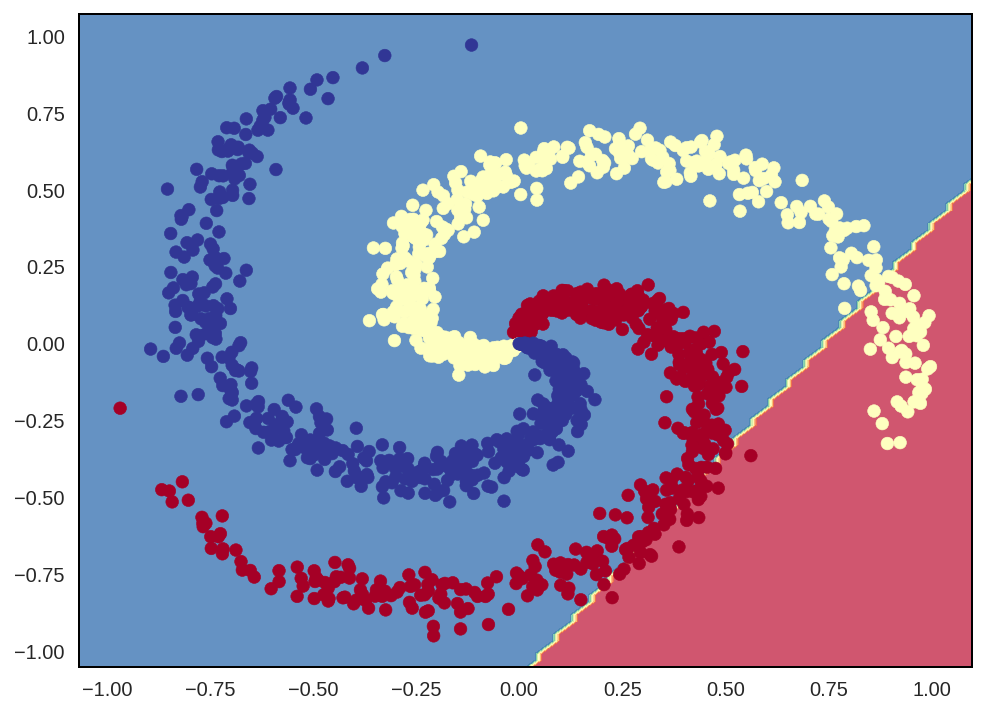

In [62]:
plot_multiclass_decisioin_boundary(model, X, y)

             precision    recall  f1-score   support

        0.0       0.34      0.06      0.10       500
        1.0       0.31      0.89      0.47       500
        2.0       0.00      0.00      0.00       500

avg / total       0.22      0.32      0.19      1500



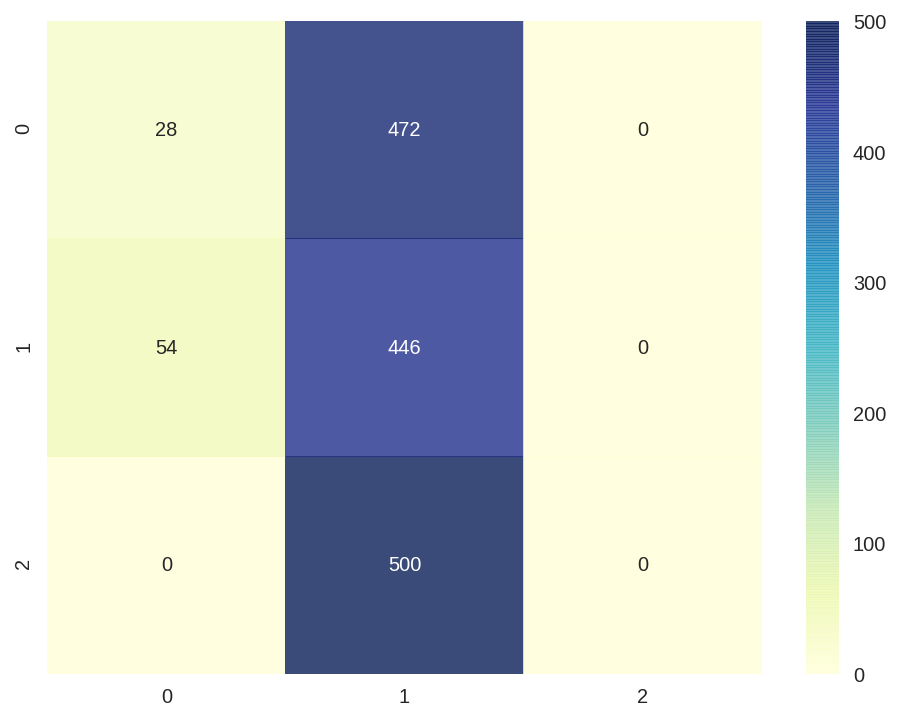

In [63]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y,y_pred))
plot_confusion_matrix(model, X, y)

## SVM

In [0]:
from sklearn.multiclass import OneVsOneClassifier

In [41]:
# support vector machine
clf = OneVsOneClassifier(svm.SVC(C=5, kernel='rbf',gamma=10,decision_function_shape='ovo'))
clf.fit(X,y)

OneVsOneClassifier(estimator=SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

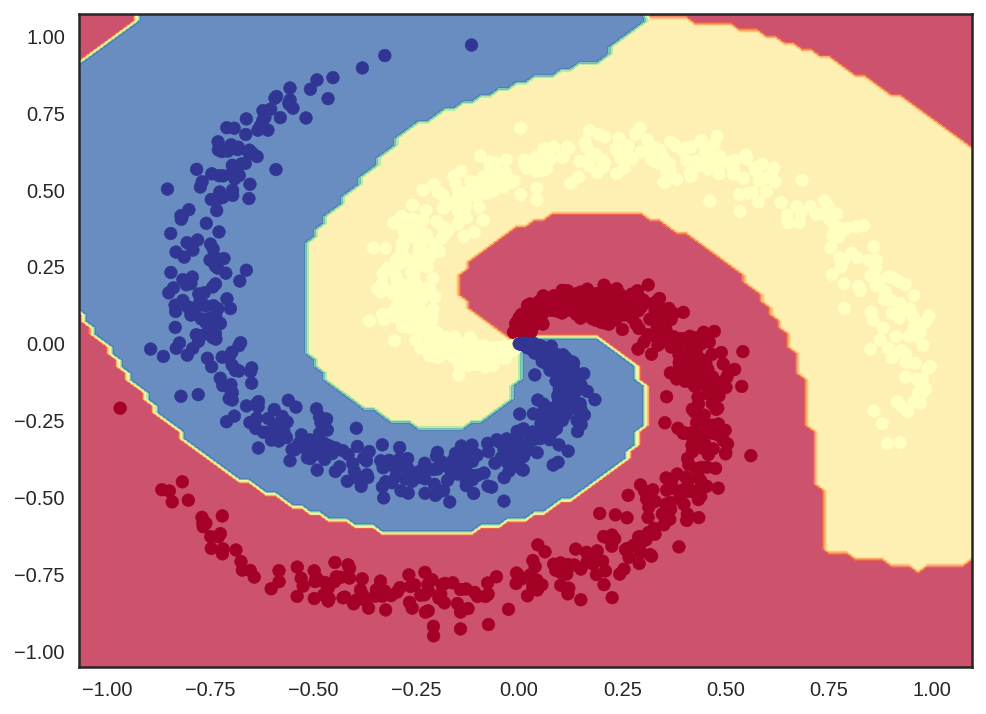

In [45]:
plot_multiclass_decisioin_boundary_notNN(clf,X,y)

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       500
        1.0       1.00      1.00      1.00       500
        2.0       0.99      1.00      1.00       500

avg / total       1.00      1.00      1.00      1500



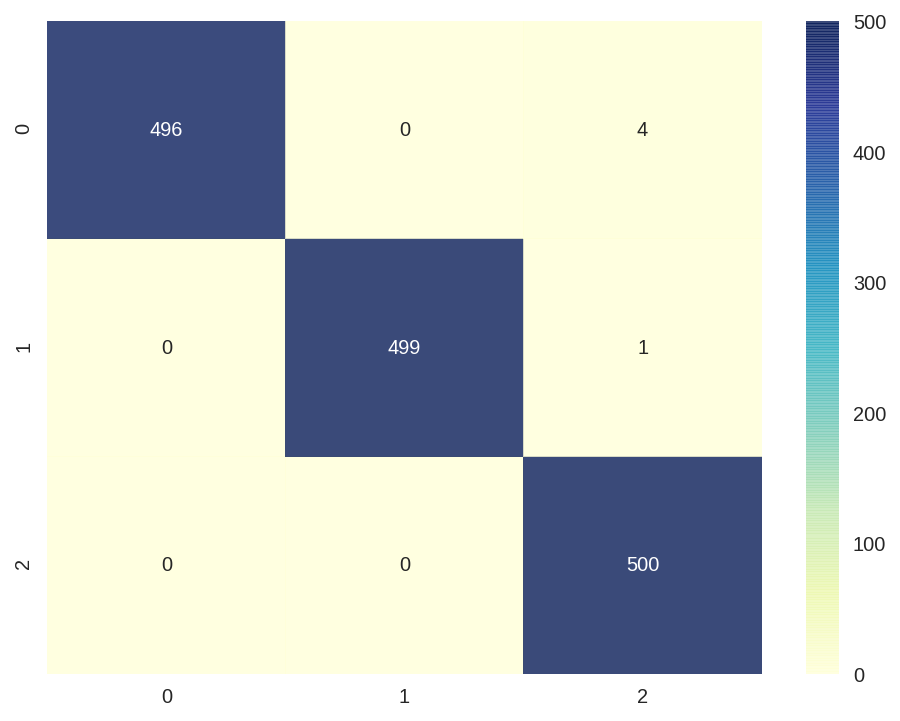

In [24]:
y_pred = clf.predict(X)
print(classification_report(y,y_pred))
plot_confusion(clf, X, y)

## Shallow NN

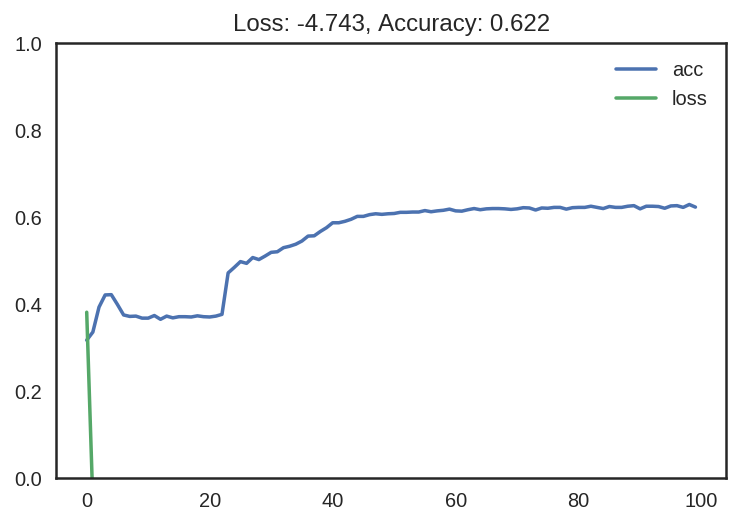

In [46]:
model = Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='tanh'))
model.add(Dense(units=2, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

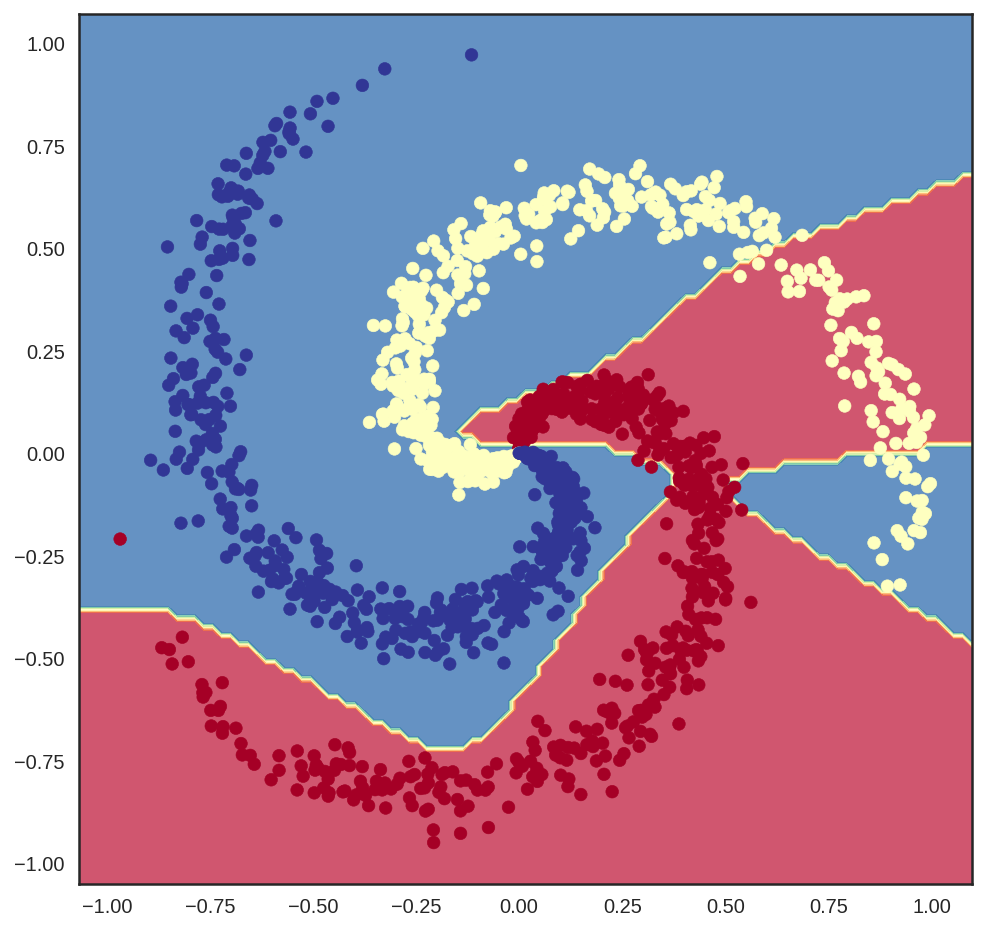

In [28]:
plot_multiclass_decisioin_boundary(model, X, y)

             precision    recall  f1-score   support

        0.0       1.00      0.89      0.94       500
        1.0       0.47      1.00      0.64       500
        2.0       0.00      0.00      0.00       500

avg / total       0.49      0.63      0.53      1500



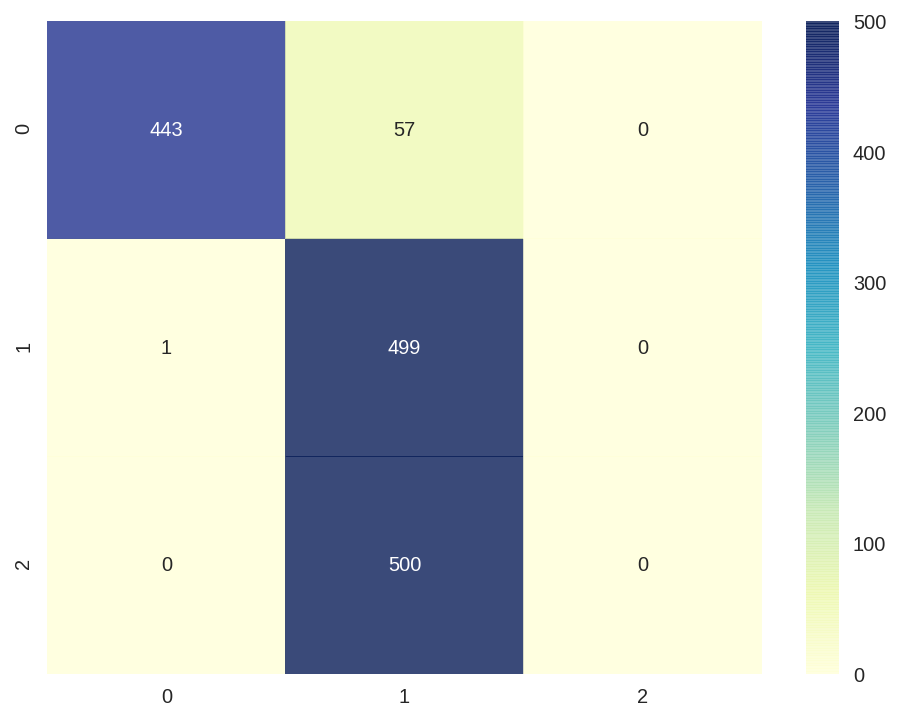

In [47]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y,y_pred))
plot_confusion_matrix(model, X, y)

## Deep Neural Network



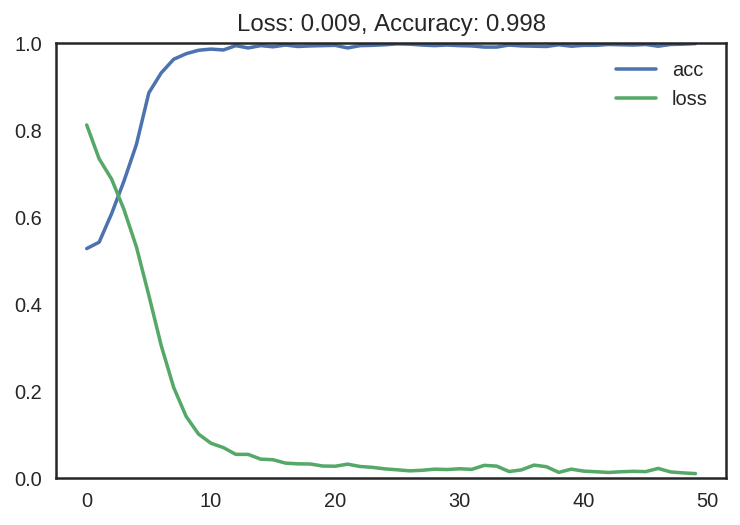

In [48]:
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))


model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=50)
plot_loss_accuracy(history)

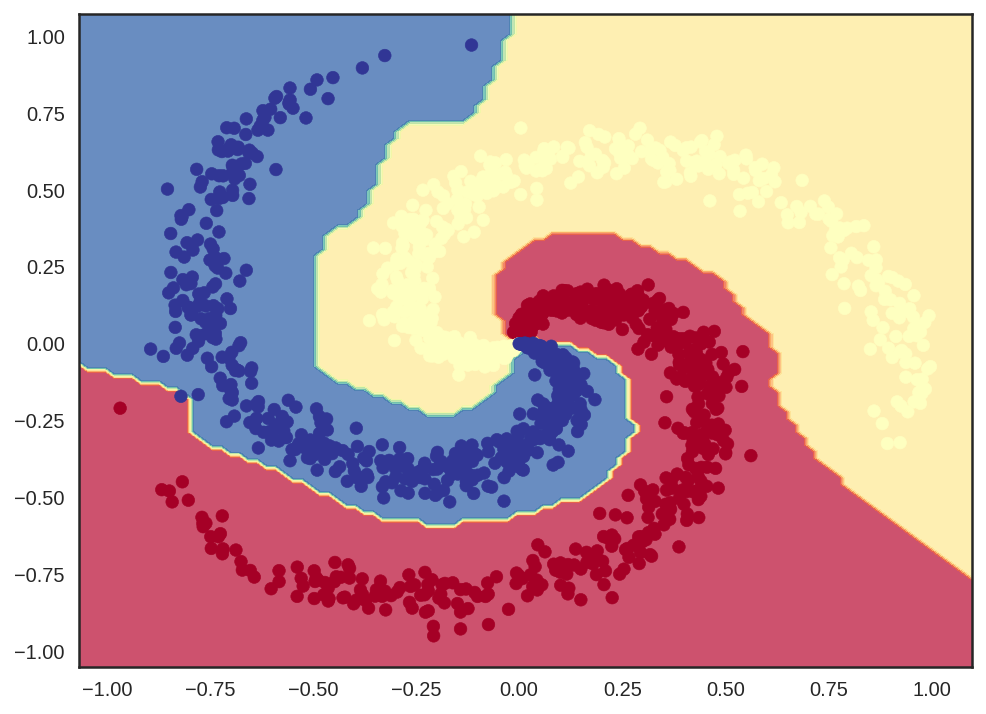

In [49]:
plot_multiclass_decisioin_boundary(model, X, y)

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       500
        1.0       1.00      1.00      1.00       500
        2.0       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1500



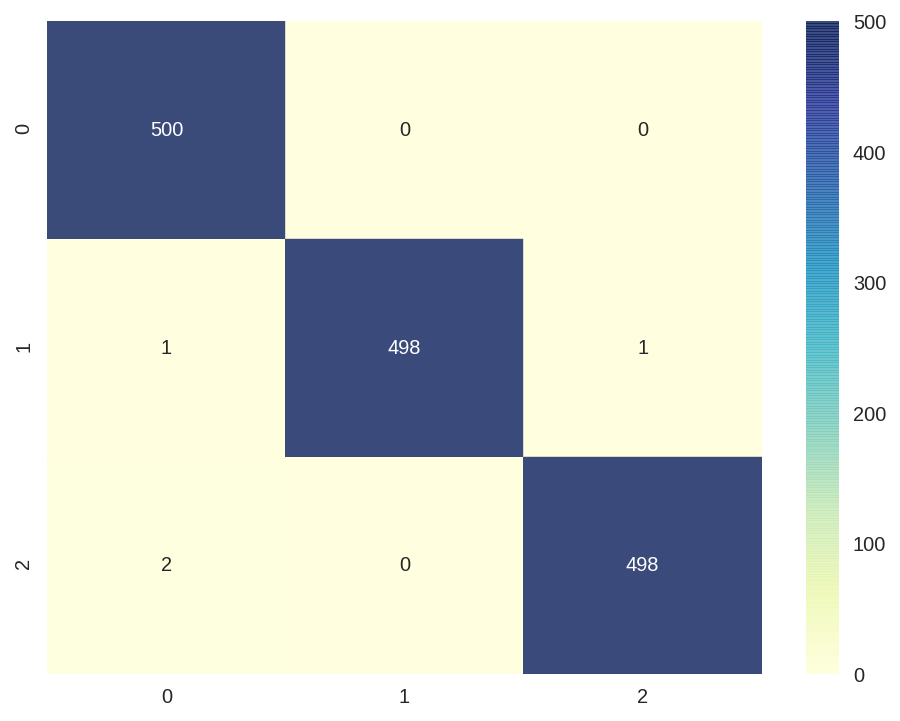

In [50]:
y_pred = model.predict_classes(X, verbose = 0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

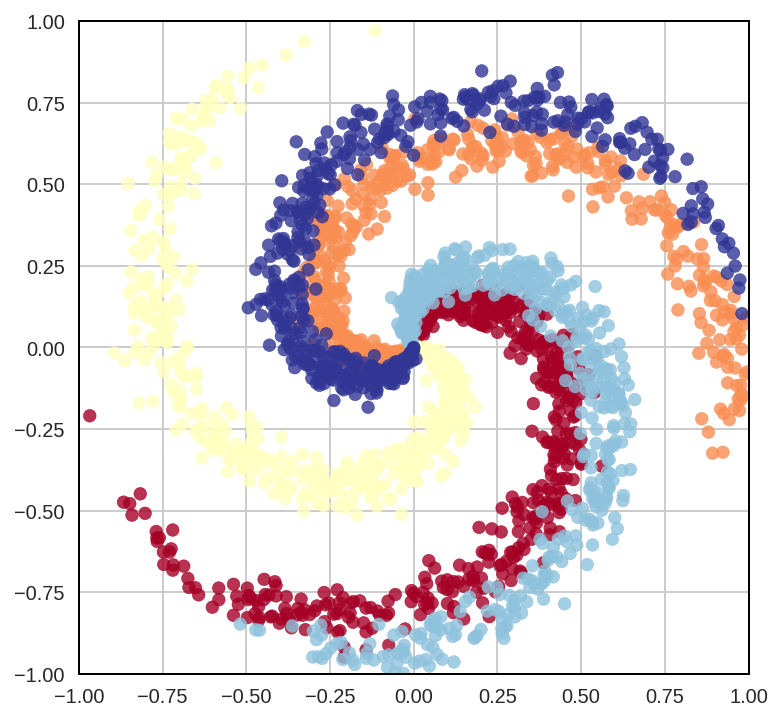

In [130]:
X, y = make_multiclass(K=5)

In [131]:
# support vector machine
clf = svm.SVC(C=5, kernel='rbf',gamma=10)
clf.fit(X,y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

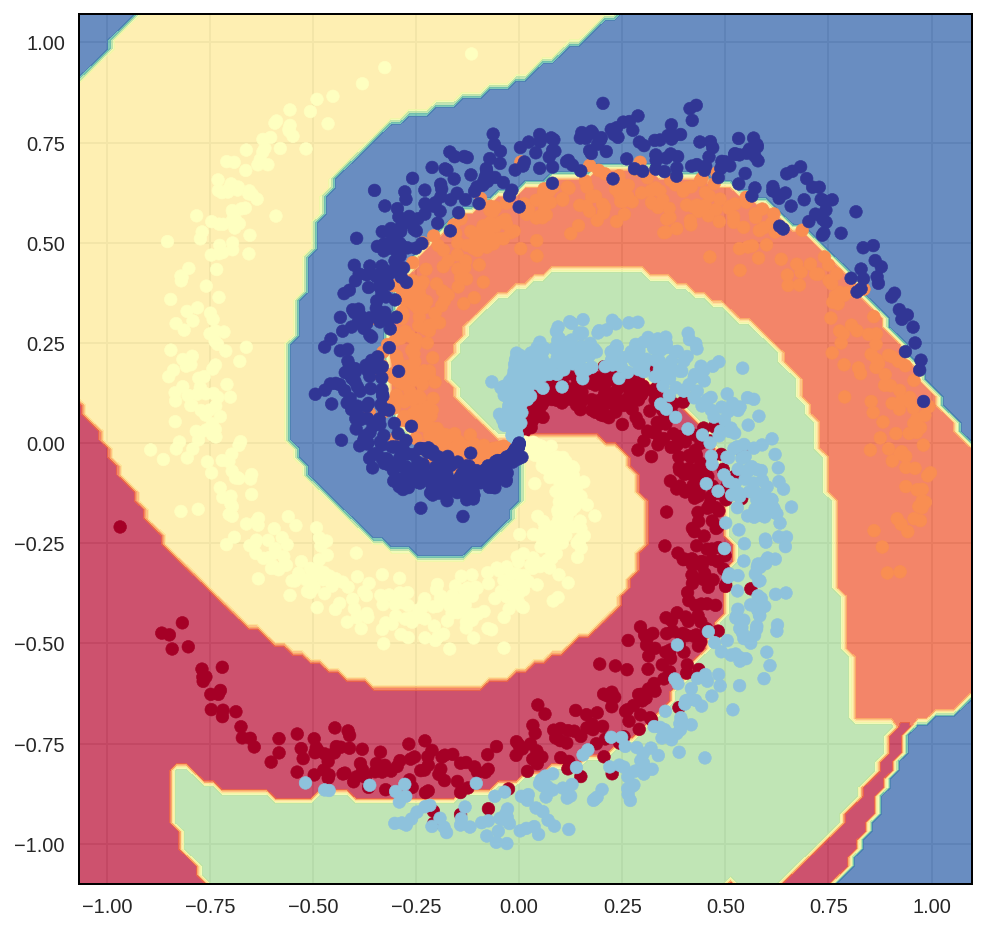

In [132]:
plot_multiclass_decisioin_boundary_notNN(clf,X,y)

             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90       500
        1.0       0.91      0.93      0.92       500
        2.0       1.00      0.99      1.00       500
        3.0       0.93      0.88      0.90       500
        4.0       0.93      0.90      0.91       500

avg / total       0.93      0.93      0.93      2500



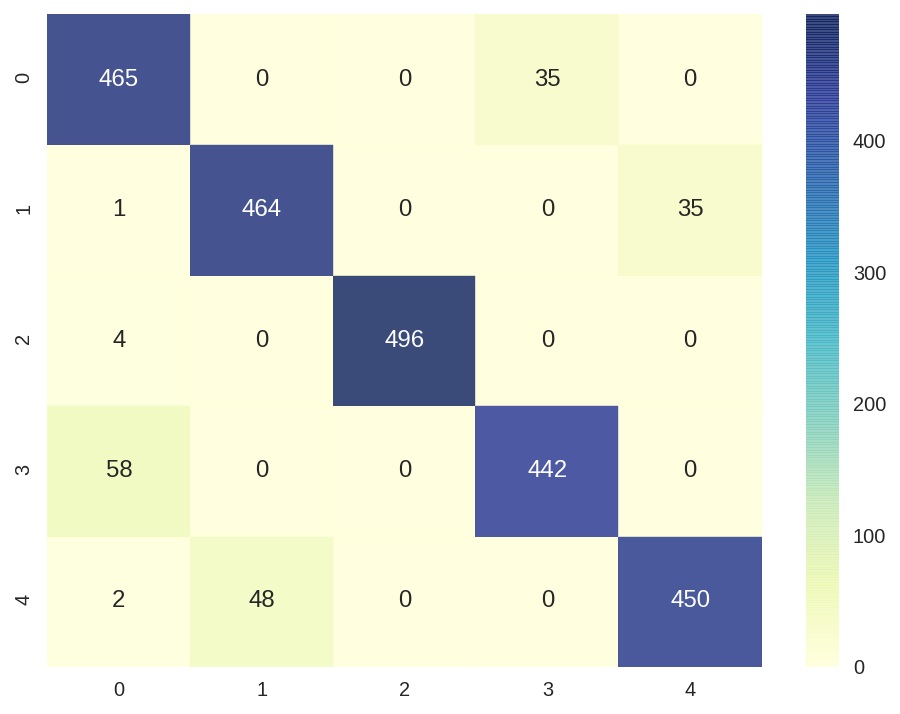

In [136]:
y_pred_1 = clf.predict(X)
print(classification_report(y, y_pred_1))
plot_confusion(clf, X, y)

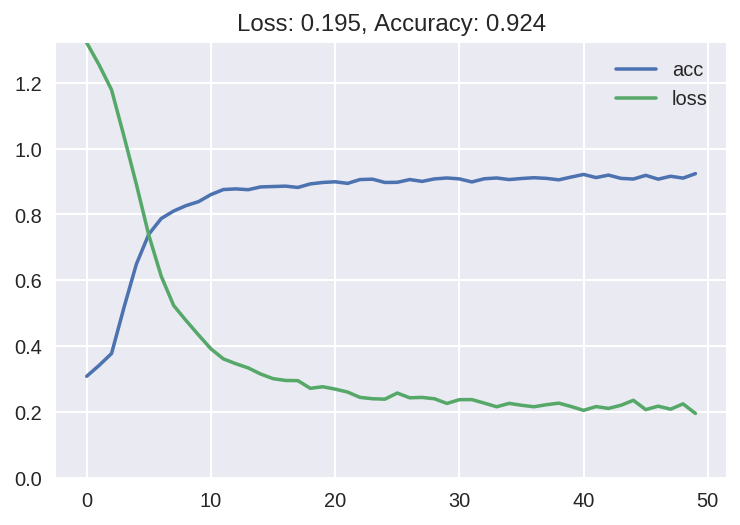

In [117]:
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(5, activation='softmax'))


model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=50)
plot_loss_accuracy(history)

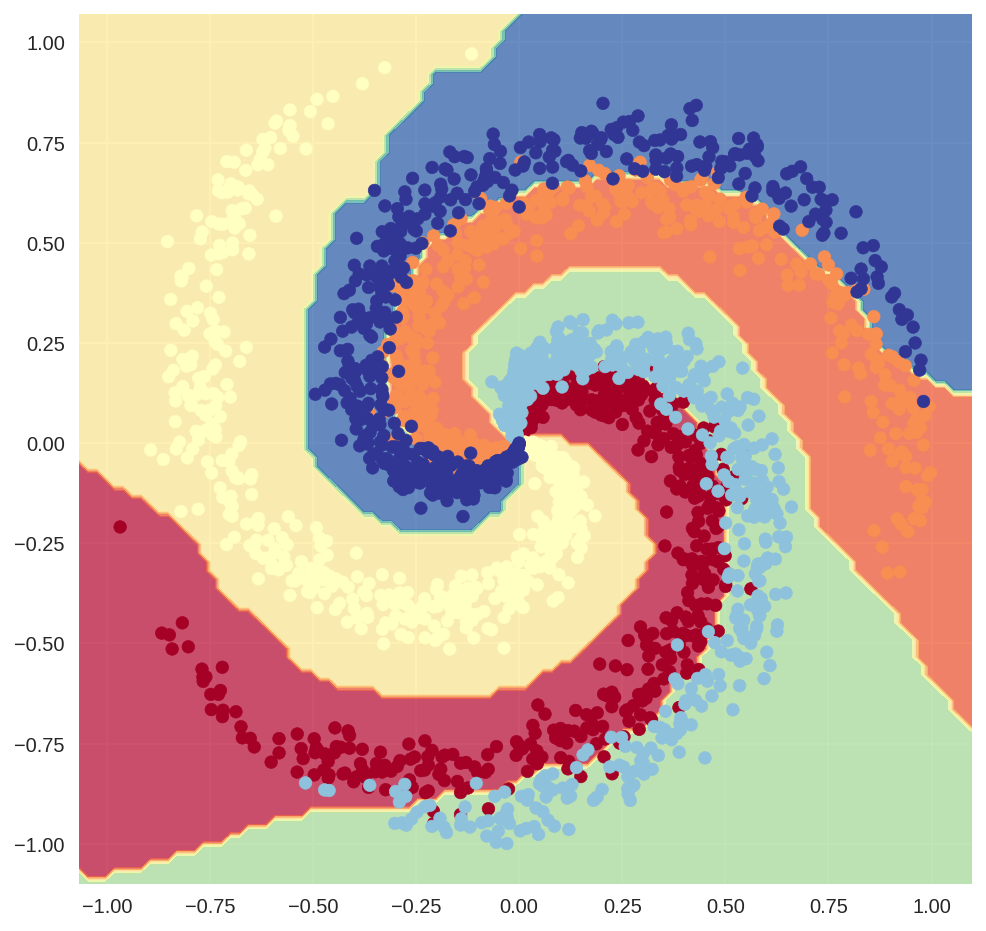

In [118]:
plot_multiclass_decisioin_boundary(model, X, y)

             precision    recall  f1-score   support

        0.0       0.92      0.90      0.91       500
        1.0       0.96      0.88      0.92       500
        2.0       1.00      1.00      1.00       500
        3.0       0.91      0.92      0.91       500
        4.0       0.88      0.97      0.92       500

avg / total       0.94      0.93      0.93      2500



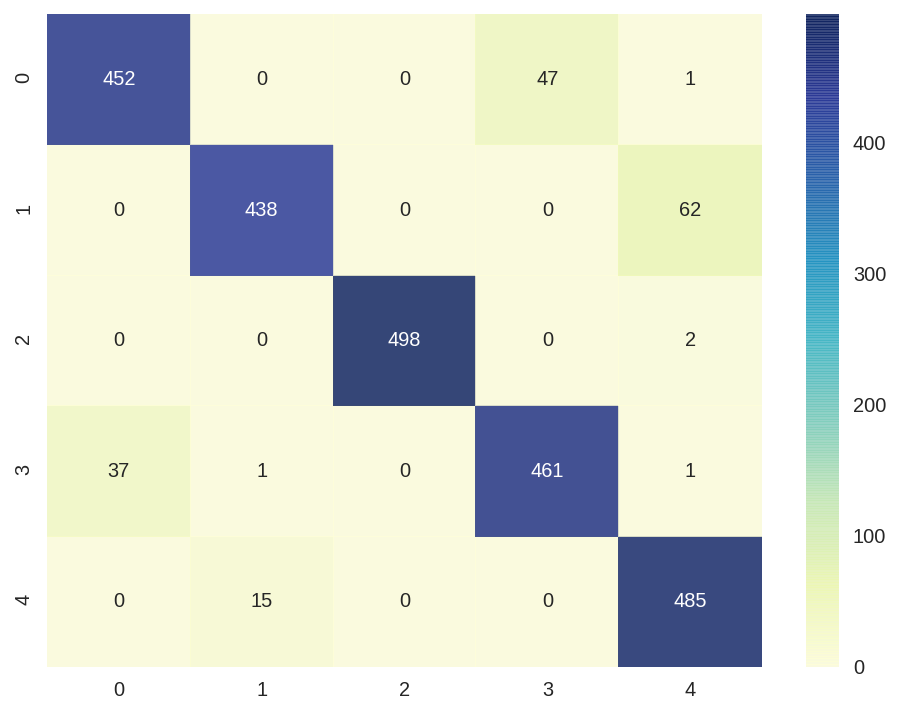

In [119]:
y_pred = model.predict_classes(X, verbose = 0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

In [138]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

Selecting previously unselected package fontconfig.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2